# Data Visualization with matplotlib

## Introduction

Effective visualization is crucial for understanding and communicating complex power system data. This lesson covers visualization techniques specifically tailored for power system analysis, from simple time series plots to complex network diagrams. You'll learn to create publication-quality figures that clearly convey technical insights to various audiences.

## Learning Objectives

By the end of this lesson, you will be able to:

1. Create effective time series visualizations for load, generation, and price data
2. Design statistical plots to analyze power system relationships and distributions
3. Build heatmaps for spatial and temporal pattern analysis
4. Develop simple network diagrams for power flow visualization
5. Combine multiple plots into comprehensive dashboards
6. Apply visualization best practices for technical communication

## Prerequisites

This lesson builds on:
- Python fundamentals (Lesson 1)
- NumPy arrays (Lesson 2)
- Pandas DataFrames (Lesson 3)
- Basic understanding of power system operations

## 1. Principles of Power System Visualization

Effective power system visualizations share several key characteristics:

### Design Principles

1. **Clarity**: Technical accuracy without overwhelming detail
2. **Context**: Include units, scales, and reference values
3. **Color Usage**: Consistent color schemes for fuel types and electrical quantities
4. **Accessibility**: Consider colorblind-friendly palettes
5. **Purpose**: Each plot should answer a specific question

### Common Power System Plot Types

- **Time Series**: Load profiles, generation output, prices
- **Statistical**: Capacity factors, heat rates, outage distributions
- **Spatial**: Transmission flows, voltage contours, congestion maps
- **Comparative**: Fuel mix, market shares, technology costs

Let's create sample data to demonstrate these principles.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import FancyBboxPatch
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Configure display settings
pd.set_option('display.precision', 2)
np.set_printoptions(precision=2)

# Define power system color scheme
FUEL_COLORS = {
    'Nuclear': '#1f77b4',    # Blue
    'Coal': '#666666',       # Dark gray
    'Natural Gas': '#ff7f0e', # Orange
    'Wind': '#2ca02c',       # Green
    'Solar': '#ffdb58',      # Yellow
    'Hydro': '#17becf',      # Cyan
    'Other': '#d62728'       # Red
}

print("Visualization libraries loaded successfully")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

Visualization libraries loaded successfully
Matplotlib version: 3.10.3
Seaborn version: 0.13.2


In [2]:
# Generate sample power system data
np.random.seed(42)

# Create 7 days of hourly data
hours = pd.date_range('2024-01-01', periods=168, freq='H')

# Load data with daily and weekly patterns
base_load = 5000  # MW
daily_pattern = 1000 * np.sin((hours.hour - 6) * np.pi / 12)
weekly_pattern = 200 * np.sin(hours.dayofweek * 2 * np.pi / 7)
random_variation = np.random.normal(0, 100, len(hours))
load = base_load + daily_pattern + weekly_pattern + random_variation
load = np.maximum(load, 3000)  # Minimum load constraint

# Initialize generation data
generation_data = pd.DataFrame({
    'timestamp': hours,
    'load': load,
    'nuclear': 1500,  # Constant baseload
})

# Coal follows load partially
generation_data['coal'] = np.minimum(2000, np.maximum(1000, load - 3500))

# Renewables with realistic patterns
generation_data['wind'] = 300 * (1 + 0.5 * np.sin(hours.hour * np.pi / 6)) * np.random.uniform(0.2, 1, len(hours))
generation_data['solar'] = 400 * np.maximum(0, np.sin((hours.hour - 6) * np.pi / 12)) * (hours.hour >= 6) * (hours.hour <= 18)

# Natural gas fills the gap
generation_data['natural_gas'] = np.maximum(0, 
    generation_data['load'] - 
    generation_data[['nuclear', 'coal', 'wind', 'solar']].sum(axis=1)
)

# Price data (correlated with load)
load_normalized = (generation_data['load'] - generation_data['load'].min()) / \
                 (generation_data['load'].max() - generation_data['load'].min())
generation_data['lmp'] = 20 + 40 * load_normalized + np.random.normal(0, 5, len(hours))

print("Sample data created:")
print(generation_data.head())
print(f"\nData shape: {generation_data.shape}")
print(f"Load range: {generation_data['load'].min():.0f} - {generation_data['load'].max():.0f} MW")

Sample data created:
            timestamp     load  nuclear    coal    wind  solar  natural_gas  \
0 2024-01-01 00:00:00  4049.67     1500  1000.0   82.48    0.0      1467.19   
1 2024-01-01 01:00:00  4020.25     1500  1000.0  185.31    0.0      1334.93   
2 2024-01-01 02:00:00  4198.74     1500  1000.0  177.19    0.0      1521.55   
3 2024-01-01 03:00:00  4445.20     1500  1000.0  177.84    0.0      1767.36   
4 2024-01-01 04:00:00  4476.58     1500  1000.0  420.62    0.0      1555.96   

     lmp  
0  24.70  
1  24.92  
2  33.57  
3  28.15  
4  34.34  

Data shape: (168, 8)
Load range: 3748 - 6258 MW


## 2. Time Series Visualization

Time series plots are fundamental in power system analysis. They show how quantities change over time and help identify patterns, trends, and anomalies.

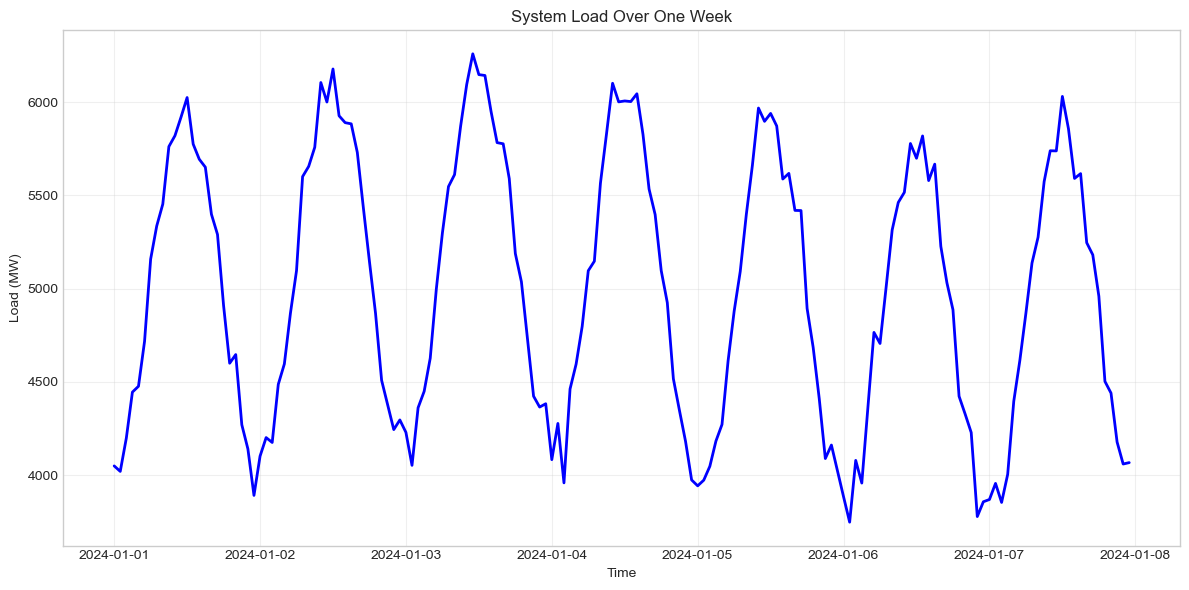

In [3]:
# Basic time series plot
plt.figure(figsize=(12, 6))
plt.plot(generation_data['timestamp'], generation_data['load'], 'b-', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Load (MW)')
plt.title('System Load Over One Week')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Enhanced Time Series with Multiple Variables

Power system analysis often requires comparing multiple time series. Here's how to create more informative plots:

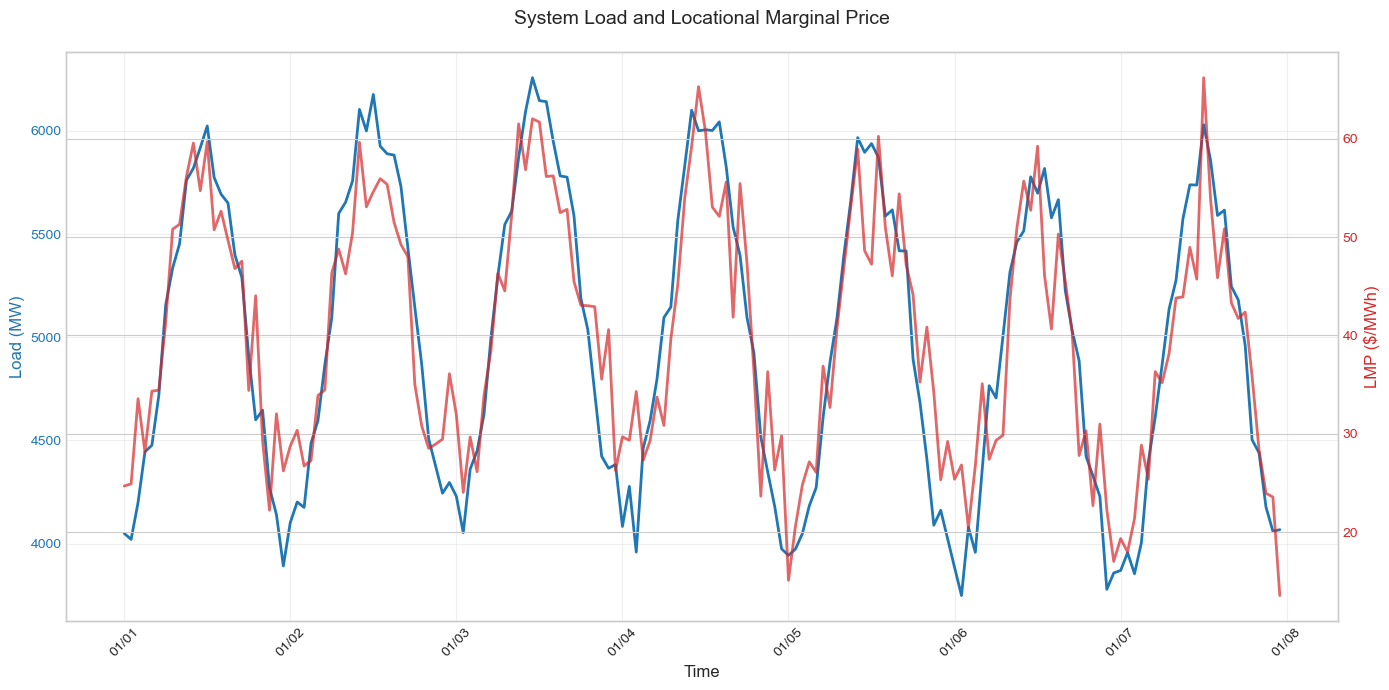

Correlation between load and price: 0.923


In [4]:
# Create a figure with dual y-axes for load and price
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot load on primary axis
color = 'tab:blue'
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Load (MW)', color=color, fontsize=12)
ax1.plot(generation_data['timestamp'], generation_data['load'], color=color, linewidth=2, label='System Load')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Create secondary axis for price
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('LMP ($/MWh)', color=color, fontsize=12)
ax2.plot(generation_data['timestamp'], generation_data['lmp'], color=color, linewidth=2, alpha=0.7, label='LMP')
ax2.tick_params(axis='y', labelcolor=color)

# Format x-axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator())
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Add title and adjust layout
ax1.set_title('System Load and Locational Marginal Price', fontsize=14, pad=20)
fig.tight_layout()
plt.show()

# Show correlation
correlation = generation_data['load'].corr(generation_data['lmp'])
print(f"Correlation between load and price: {correlation:.3f}")

### Generation Stack Plot

A stack plot shows how different generators contribute to meeting load over time:

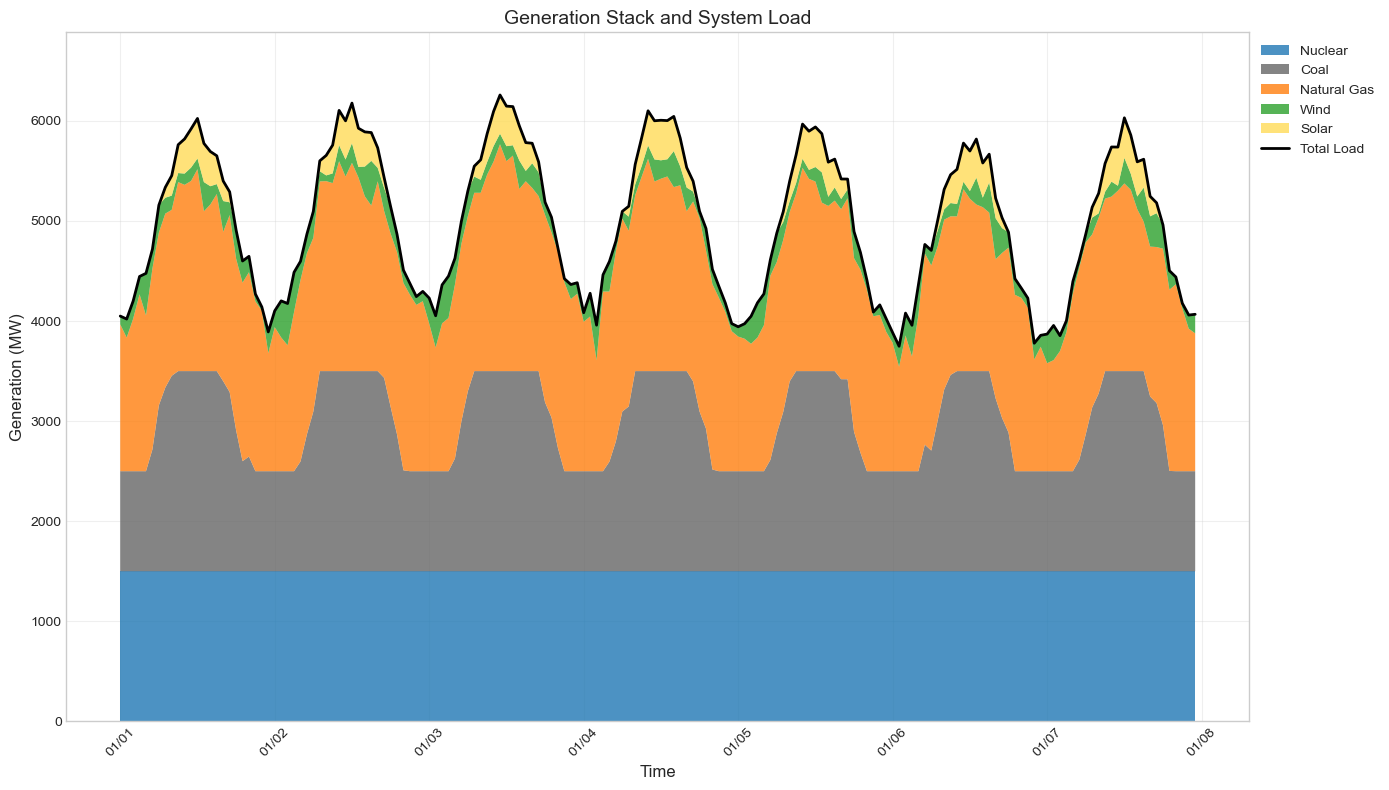


Generation Mix (Weekly Total):
Nuclear: 30.0%
Coal: 30.0%
Natural Gas: 33.9%
Wind: 3.5%
Solar: 2.5%


In [5]:
# Create generation stack plot
fig, ax = plt.subplots(figsize=(14, 8))

# Define generation types and their colors
gen_types = ['nuclear', 'coal', 'natural_gas', 'wind', 'solar']
colors = ['#1f77b4', '#666666', '#ff7f0e', '#2ca02c', '#ffdb58']
labels = ['Nuclear', 'Coal', 'Natural Gas', 'Wind', 'Solar']

# Create the stack plot
ax.stackplot(generation_data['timestamp'], 
             [generation_data[gen] for gen in gen_types],
             labels=labels,
             colors=colors,
             alpha=0.8)

# Overlay load line
ax.plot(generation_data['timestamp'], generation_data['load'], 
        'k-', linewidth=2, label='Total Load')

# Formatting
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Generation (MW)', fontsize=12)
ax.set_title('Generation Stack and System Load', fontsize=14)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid(True, alpha=0.3)
ax.set_ylim(0, generation_data['load'].max() * 1.1)

# Format dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.xaxis.set_major_locator(mdates.DayLocator())
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# Calculate generation mix percentages
total_gen = generation_data[gen_types].sum().sum()
print("\nGeneration Mix (Weekly Total):")
for gen, label in zip(gen_types, labels):
    pct = generation_data[gen].sum() / total_gen * 100
    print(f"{label}: {pct:.1f}%")

```{admonition} Exercise 1: Create a Daily Generation Stack Plot
:class: tip

Create a generation stack plot for just one day (January 3rd) that shows:
1. Hourly generation by fuel type as a stacked area
2. Total load as a black line
3. Highlight the peak demand hour with a vertical line
4. Add annotations showing renewable penetration at noon

```

In [6]:
# Exercise 1: Your code here
# Create a daily generation stack plot with annotations

# Your solution:

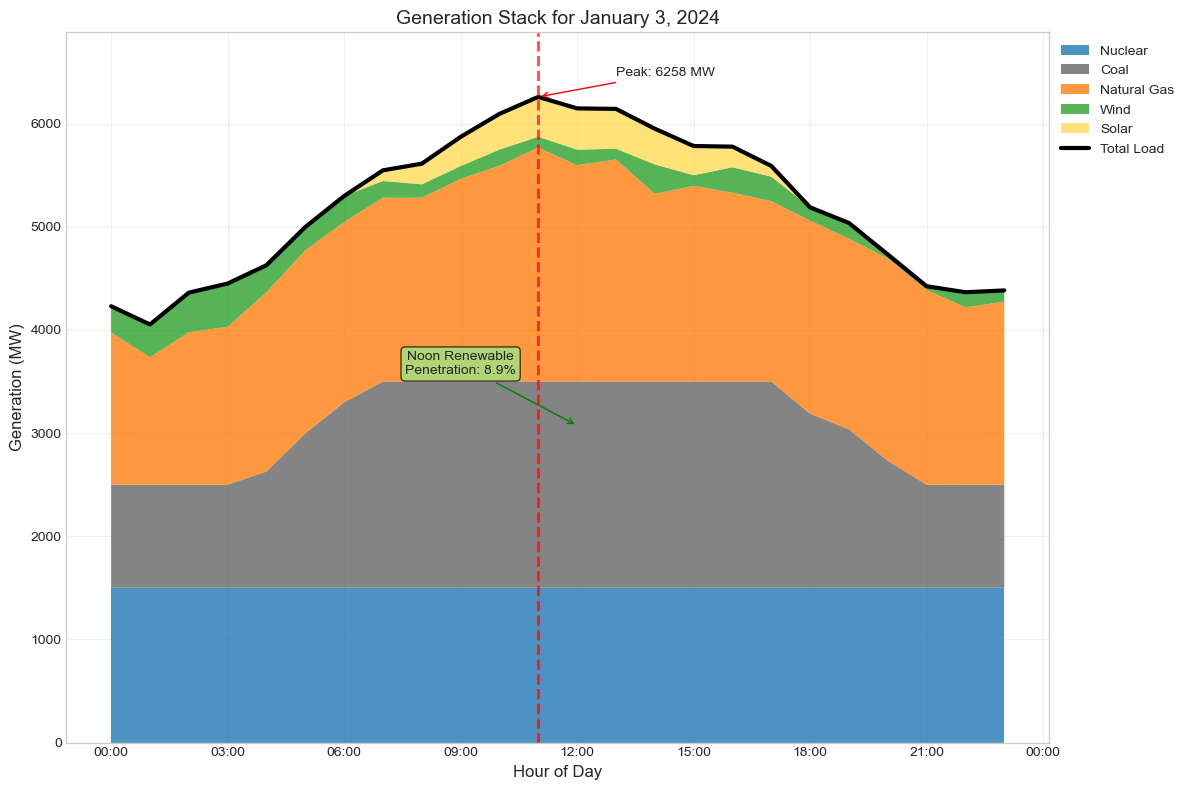

In [7]:
# Solution
# Filter data for January 3rd
jan3_data = generation_data[(generation_data['timestamp'] >= '2024-01-03') & 
                            (generation_data['timestamp'] < '2024-01-04')].copy()

fig, ax = plt.subplots(figsize=(12, 8))

# Create stack plot
ax.stackplot(jan3_data['timestamp'], 
             [jan3_data[gen] for gen in gen_types],
             labels=labels,
             colors=colors,
             alpha=0.8)

# Add load line
ax.plot(jan3_data['timestamp'], jan3_data['load'], 
        'k-', linewidth=3, label='Total Load')

# Find and highlight peak hour
peak_idx = jan3_data['load'].idxmax()
peak_time = jan3_data.loc[peak_idx, 'timestamp']
peak_load = jan3_data.loc[peak_idx, 'load']

ax.axvline(peak_time, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax.annotate(f'Peak: {peak_load:.0f} MW', 
            xy=(peak_time, peak_load), 
            xytext=(peak_time + pd.Timedelta(hours=2), peak_load + 200),
            arrowprops=dict(arrowstyle='->', color='red'),
            fontsize=10, ha='left')

# Calculate and annotate renewable penetration at noon
noon_idx = jan3_data[jan3_data['timestamp'].dt.hour == 12].index[0]
noon_renewable = jan3_data.loc[noon_idx, ['wind', 'solar']].sum()
noon_total = jan3_data.loc[noon_idx, gen_types].sum()
renewable_pct = noon_renewable / noon_total * 100

noon_time = jan3_data.loc[noon_idx, 'timestamp']
ax.annotate(f'Noon Renewable\nPenetration: {renewable_pct:.1f}%', 
            xy=(noon_time, noon_total/2), 
            xytext=(noon_time - pd.Timedelta(hours=3), noon_total/2 + 500),
            arrowprops=dict(arrowstyle='->', color='green'),
            fontsize=10, ha='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen', alpha=0.7))

# Formatting
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Generation (MW)', fontsize=12)
ax.set_title('Generation Stack for January 3, 2024', fontsize=14)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid(True, alpha=0.3)
ax.set_ylim(0, jan3_data['load'].max() * 1.1)

# Format x-axis for hours
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:00'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))

plt.tight_layout()
plt.show()

## 3. Statistical Visualizations

Statistical plots help understand distributions, relationships, and patterns in power system data. These are essential for reliability analysis, planning studies, and performance evaluation.

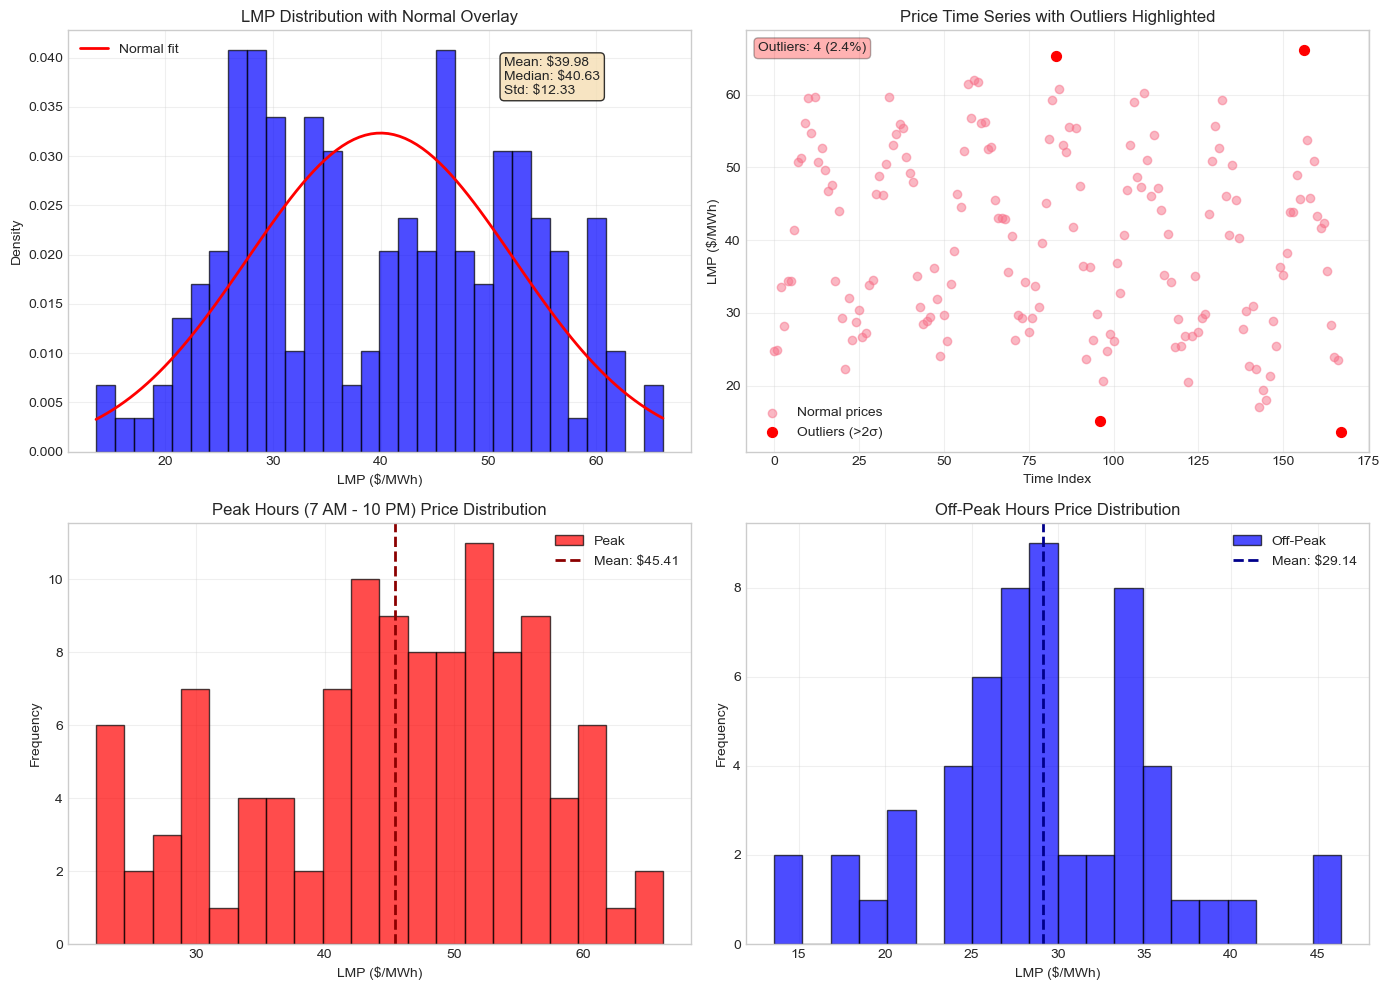


Price Statistics Summary:
Overall - Mean: $39.98, Std: $12.33
Peak hours - Mean: $45.41, Std: $10.85
Off-peak hours - Mean: $29.14, Std: $6.70
Peak premium: $16.26 (55.8%)


In [8]:
# Solution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Overall price distribution with normal overlay
ax = axes[0, 0]
n, bins, patches = ax.hist(generation_data['lmp'], bins=30, density=True, 
                           alpha=0.7, color='blue', edgecolor='black')

# Fit normal distribution
mu, sigma = generation_data['lmp'].mean(), generation_data['lmp'].std()
x = np.linspace(generation_data['lmp'].min(), generation_data['lmp'].max(), 100)
ax.plot(x, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5*((x - mu)/sigma)**2), 
        'r-', linewidth=2, label='Normal fit')

ax.set_xlabel('LMP ($/MWh)')
ax.set_ylabel('Density')
ax.set_title('LMP Distribution with Normal Overlay')
ax.legend()
ax.grid(True, alpha=0.3)

# Add statistics
stats_text = f'Mean: ${mu:.2f}\nMedian: ${generation_data["lmp"].median():.2f}\nStd: ${sigma:.2f}'
ax.text(0.7, 0.85, stats_text, transform=ax.transAxes, 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 2. Identify outliers
ax = axes[0, 1]
outlier_threshold = 2
z_scores = np.abs((generation_data['lmp'] - mu) / sigma)
outliers = generation_data[z_scores > outlier_threshold]

ax.scatter(generation_data.index, generation_data['lmp'], alpha=0.5, label='Normal prices')
ax.scatter(outliers.index, outliers['lmp'], color='red', s=50, label='Outliers (>2σ)')
ax.set_xlabel('Time Index')
ax.set_ylabel('LMP ($/MWh)')
ax.set_title('Price Time Series with Outliers Highlighted')
ax.legend()
ax.grid(True, alpha=0.3)

# Add outlier count
ax.text(0.02, 0.95, f'Outliers: {len(outliers)} ({len(outliers)/len(generation_data)*100:.1f}%)', 
        transform=ax.transAxes, bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))

# 3. Peak vs Off-peak distributions
# Define peak hours
generation_data['hour'] = generation_data['timestamp'].dt.hour
generation_data['is_peak'] = generation_data['hour'].between(7, 22)

peak_prices = generation_data[generation_data['is_peak']]['lmp']
offpeak_prices = generation_data[~generation_data['is_peak']]['lmp']

# Peak hours histogram
ax = axes[1, 0]
ax.hist(peak_prices, bins=20, alpha=0.7, color='red', edgecolor='black', label='Peak')
ax.axvline(peak_prices.mean(), color='darkred', linestyle='--', linewidth=2, label=f'Mean: ${peak_prices.mean():.2f}')
ax.set_xlabel('LMP ($/MWh)')
ax.set_ylabel('Frequency')
ax.set_title('Peak Hours (7 AM - 10 PM) Price Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# Off-peak hours histogram
ax = axes[1, 1]
ax.hist(offpeak_prices, bins=20, alpha=0.7, color='blue', edgecolor='black', label='Off-Peak')
ax.axvline(offpeak_prices.mean(), color='darkblue', linestyle='--', linewidth=2, label=f'Mean: ${offpeak_prices.mean():.2f}')
ax.set_xlabel('LMP ($/MWh)')
ax.set_ylabel('Frequency')
ax.set_title('Off-Peak Hours Price Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nPrice Statistics Summary:")
print(f"Overall - Mean: ${mu:.2f}, Std: ${sigma:.2f}")
print(f"Peak hours - Mean: ${peak_prices.mean():.2f}, Std: ${peak_prices.std():.2f}")
print(f"Off-peak hours - Mean: ${offpeak_prices.mean():.2f}, Std: ${offpeak_prices.std():.2f}")
print(f"Peak premium: ${peak_prices.mean() - offpeak_prices.mean():.2f} ({(peak_prices.mean()/offpeak_prices.mean() - 1)*100:.1f}%)")

```{admonition} Exercise 2: Statistical Analysis of Price Distributions
:class: tip

Create a comprehensive statistical visualization of LMP prices that includes:
1. Histogram showing price distribution with normal curve overlay
2. Identify and mark price outliers (> 2 standard deviations)
3. Create separate histograms for peak (7 AM - 10 PM) and off-peak hours
4. Add statistics (mean, median, std) as text annotations

```

In [9]:
# Exercise 2: Your code here
# Create statistical analysis of price distributions

# Your solution:

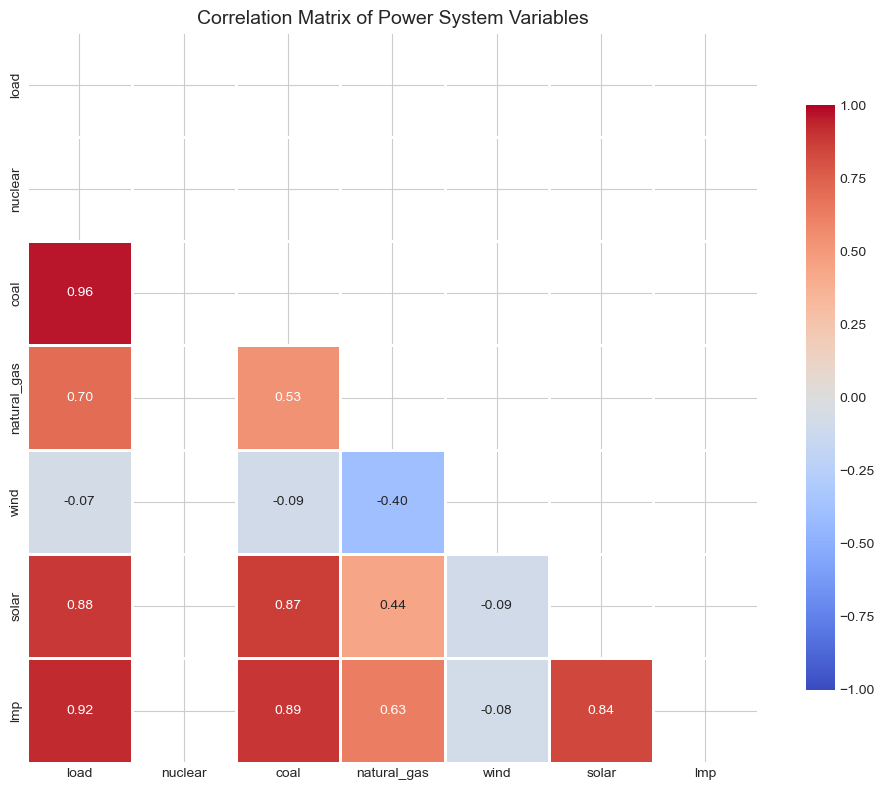

Strong correlations (|r| > 0.7):
load vs coal: 0.965
load vs solar: 0.884
load vs lmp: 0.923
coal vs solar: 0.872
coal vs lmp: 0.895
solar vs lmp: 0.841


In [10]:
# Create correlation matrix for all variables
corr_vars = ['load', 'nuclear', 'coal', 'natural_gas', 'wind', 'solar', 'lmp']
correlation_matrix = generation_data[corr_vars].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, vmin=-1, vmax=1,
            square=True, linewidths=1, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Power System Variables', fontsize=14)
plt.tight_layout()
plt.show()

# Identify strong correlations
print("Strong correlations (|r| > 0.7):")
for i in range(len(corr_vars)):
    for j in range(i+1, len(corr_vars)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            print(f"{corr_vars[i]} vs {corr_vars[j]}: {corr_val:.3f}")

### Correlation Matrix Visualization

## 4. Heatmaps and Matrix Visualizations

Heatmaps are excellent for visualizing patterns across two dimensions, such as time and location, or for showing correlations between multiple variables.

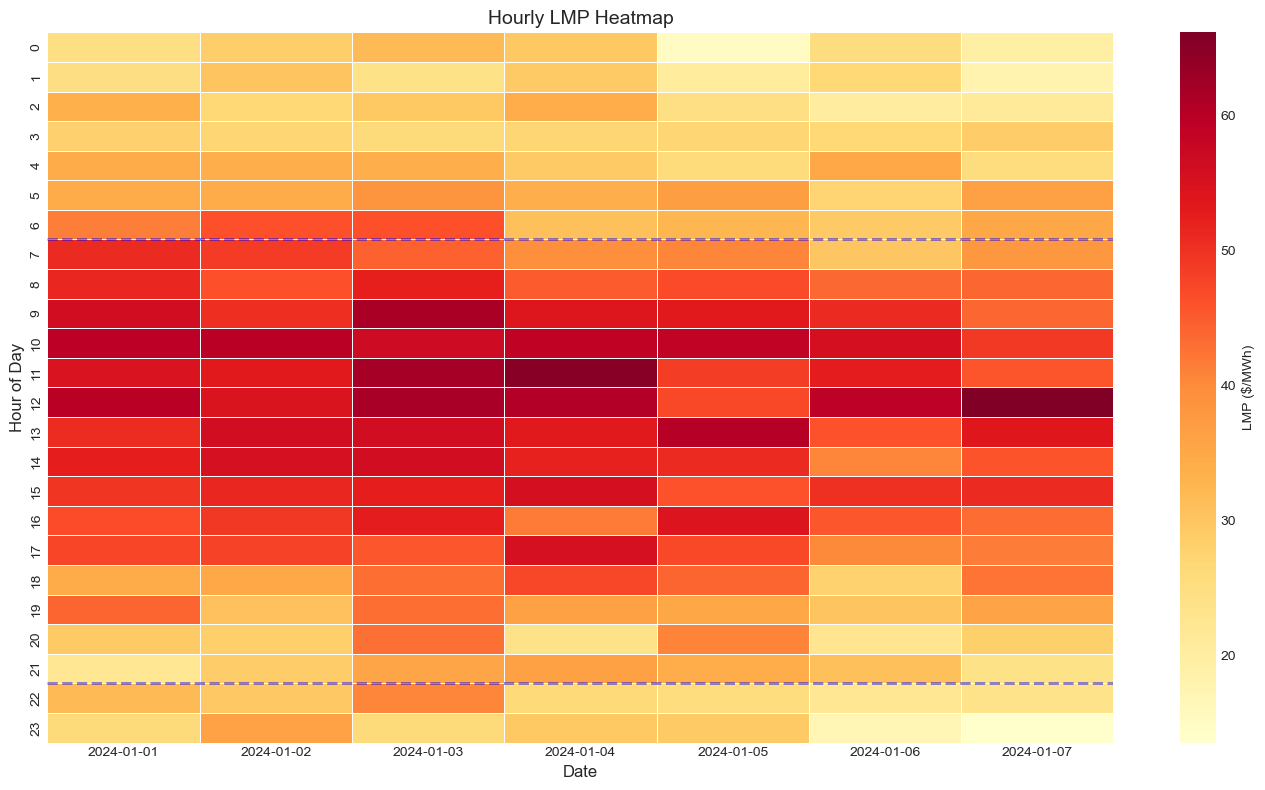

Price patterns:
Average price by hour of day:
Highest average price hour: 12:00 ($58.48)
Lowest average price hour: 1:00 ($24.88)


In [12]:
# Create hourly price heatmap for the week
# Reshape data for heatmap
generation_data['day'] = generation_data['timestamp'].dt.date
generation_data['hour'] = generation_data['timestamp'].dt.hour

# Pivot to create matrix
price_matrix = generation_data.pivot_table(values='lmp', index='hour', columns='day')

# Create the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(price_matrix, cmap='YlOrRd', cbar_kws={'label': 'LMP ($/MWh)'}, 
            annot=False, fmt='.1f', linewidths=0.5)
plt.title('Hourly LMP Heatmap', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Hour of Day', fontsize=12)

# Highlight peak hours
plt.axhline(y=7, color='blue', linewidth=2, linestyle='--', alpha=0.5)
plt.axhline(y=22, color='blue', linewidth=2, linestyle='--', alpha=0.5)
plt.text(len(price_matrix.columns) + 0.5, 14.5, 'Peak Hours', rotation=270, 
         va='center', fontsize=10, color='blue')

plt.tight_layout()
plt.show()

# Identify patterns
print("Price patterns:")
print(f"Average price by hour of day:")
hourly_avg = generation_data.groupby('hour')['lmp'].mean()
print(f"Highest average price hour: {hourly_avg.idxmax()}:00 (${hourly_avg.max():.2f})")
print(f"Lowest average price hour: {hourly_avg.idxmin()}:00 (${hourly_avg.min():.2f})")

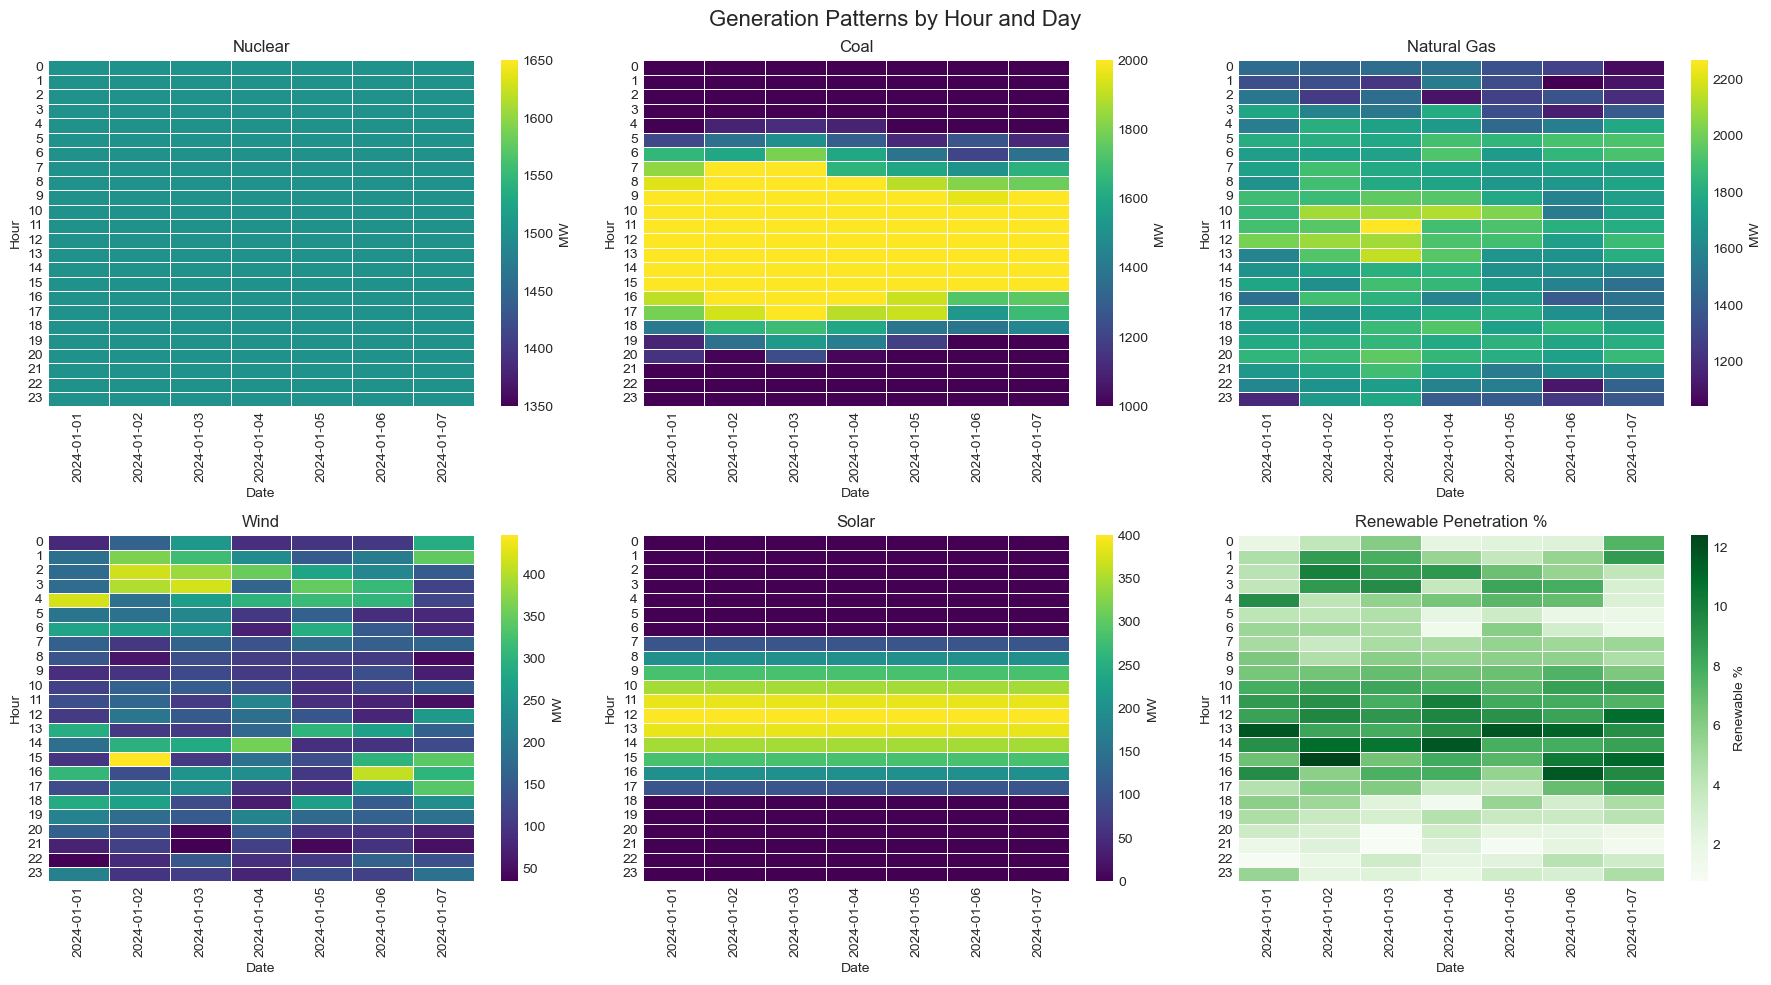

In [13]:
# Create a comprehensive generation pattern heatmap
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Generation Patterns by Hour and Day', fontsize=16)

# Create heatmaps for each generation type
for idx, (gen_type, ax) in enumerate(zip(gen_types, axes.flat)):
    gen_matrix = generation_data.pivot_table(values=gen_type, index='hour', columns='day')
    sns.heatmap(gen_matrix, cmap='viridis', ax=ax, 
                cbar_kws={'label': 'MW'}, linewidths=0.5)
    ax.set_title(gen_type.replace('_', ' ').title())
    ax.set_xlabel('Date')
    ax.set_ylabel('Hour')

# Use the last subplot for renewable penetration
renewable_pct = (generation_data['wind'] + generation_data['solar']) / generation_data[gen_types].sum(axis=1) * 100
generation_data['renewable_pct'] = renewable_pct
ren_matrix = generation_data.pivot_table(values='renewable_pct', index='hour', columns='day')

ax = axes[1, 2]
sns.heatmap(ren_matrix, cmap='Greens', ax=ax, 
            cbar_kws={'label': 'Renewable %'}, linewidths=0.5)
ax.set_title('Renewable Penetration %')
ax.set_xlabel('Date')
ax.set_ylabel('Hour')

plt.tight_layout()
plt.show()

### Generation Pattern Heatmap

```{admonition} Exercise 3: Create a Congestion Heatmap
:class: tip

Simulate transmission congestion by creating price differences between nodes and visualize:
1. Create synthetic price data for 3 nodes with varying congestion patterns
2. Calculate price spreads between nodes
3. Create a heatmap showing hourly congestion patterns
4. Identify and annotate the most congested hours

```

In [15]:
# Exercise 3: Your code here
# Create congestion heatmap

# Your solution:

## 5. Network Diagrams

While full power system network visualization typically requires specialized tools, we can create simple network diagrams to illustrate concepts and small systems.

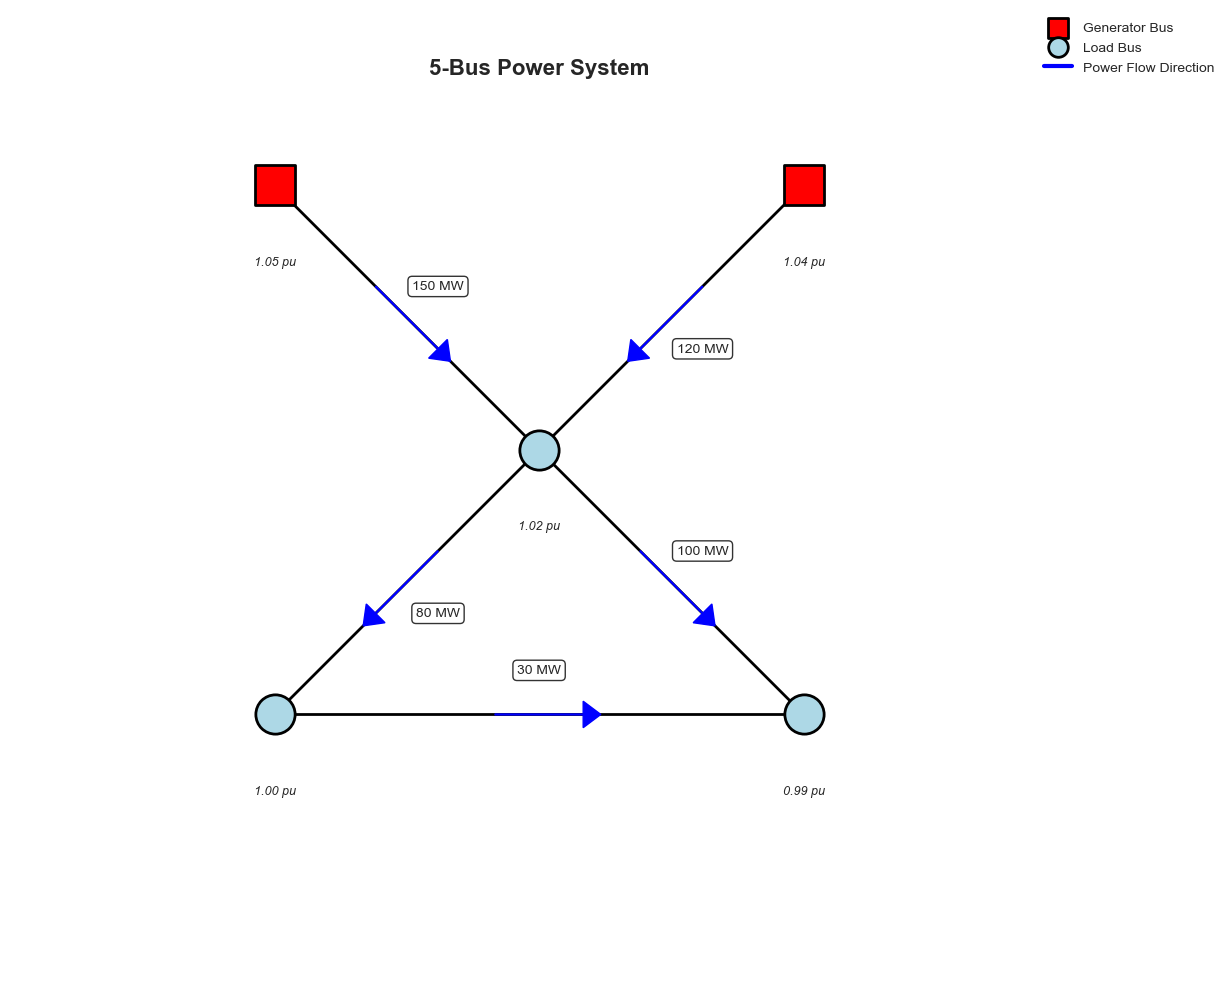

Total Generation: 270 MW
Total Load: 30 MW
System Losses: 240 MW


In [16]:
# Create a simple 5-bus power system diagram
fig, ax = plt.subplots(figsize=(12, 10))

# Define bus positions
bus_positions = {
    1: (0.2, 0.8),   # Generator bus
    2: (0.8, 0.8),   # Generator bus
    3: (0.5, 0.5),   # Load bus
    4: (0.2, 0.2),   # Load bus
    5: (0.8, 0.2)    # Load bus
}

# Define line connections (from_bus, to_bus, flow_MW)
lines = [
    (1, 3, 150),
    (2, 3, 120),
    (3, 4, 80),
    (3, 5, 100),
    (4, 5, 30)
]

# Draw buses
bus_size = 800
for bus_id, (x, y) in bus_positions.items():
    if bus_id in [1, 2]:  # Generator buses
        ax.scatter(x, y, s=bus_size, c='red', marker='s', 
                  edgecolors='black', linewidth=2, zorder=5)
        ax.text(x, y, f'G{bus_id}', ha='center', va='center', 
                fontsize=12, fontweight='bold', color='white')
    else:  # Load buses
        ax.scatter(x, y, s=bus_size, c='lightblue', marker='o', 
                  edgecolors='black', linewidth=2, zorder=5)
        ax.text(x, y, f'B{bus_id}', ha='center', va='center', 
                fontsize=12, fontweight='bold')

# Draw lines with power flows
for from_bus, to_bus, flow in lines:
    x1, y1 = bus_positions[from_bus]
    x2, y2 = bus_positions[to_bus]
    
    # Draw line
    ax.plot([x1, x2], [y1, y2], 'k-', linewidth=2, zorder=1)
    
    # Calculate midpoint for flow label
    mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
    
    # Calculate flow direction arrow
    dx, dy = x2 - x1, y2 - y1
    length = np.sqrt(dx**2 + dy**2)
    dx_norm, dy_norm = dx / length, dy / length
    
    # Draw arrow
    arrow_start_x = mid_x - 0.05 * dx_norm
    arrow_start_y = mid_y - 0.05 * dy_norm
    ax.arrow(arrow_start_x, arrow_start_y, 0.1 * dx_norm, 0.1 * dy_norm, 
            head_width=0.03, head_length=0.02, fc='blue', ec='blue', zorder=3)
    
    # Add flow label
    # Offset perpendicular to line
    perp_x, perp_y = -dy_norm * 0.05, dx_norm * 0.05
    ax.text(mid_x + perp_x, mid_y + perp_y, f'{flow} MW', 
           ha='center', va='center', fontsize=10,
           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# Add voltage annotations
voltages = {1: 1.05, 2: 1.04, 3: 1.02, 4: 1.00, 5: 0.99}
for bus_id, voltage in voltages.items():
    x, y = bus_positions[bus_id]
    ax.text(x, y - 0.08, f'{voltage:.2f} pu', ha='center', va='top', 
           fontsize=9, style='italic')

# Add legend and labels
ax.text(0.5, 0.95, '5-Bus Power System', ha='center', va='top', 
        fontsize=16, fontweight='bold', transform=ax.transAxes)

# Legend
legend_elements = [
    plt.scatter([], [], c='red', marker='s', s=200, edgecolors='black', 
                linewidth=2, label='Generator Bus'),
    plt.scatter([], [], c='lightblue', marker='o', s=200, edgecolors='black', 
                linewidth=2, label='Load Bus'),
    plt.Line2D([0], [0], color='blue', linewidth=3, label='Power Flow Direction')
]
ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))

# Format plot
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.0)
ax.set_aspect('equal')
ax.axis('off')

plt.tight_layout()
plt.show()

# Print system summary
total_gen = sum(flow for _, to_bus, flow in lines if to_bus == 3)
total_load = sum(flow for from_bus, _, flow in lines if from_bus in [3, 4, 5] and from_bus != 3)
print(f"Total Generation: {total_gen} MW")
print(f"Total Load: {total_load} MW")
print(f"System Losses: {total_gen - total_load} MW")

```{admonition} Exercise 4: Create a Network Voltage Contour
:class: tip

Enhance the network diagram by:
1. Creating a voltage contour map overlay
2. Color-coding buses by voltage magnitude
3. Adding line loading percentages
4. Highlighting overloaded lines (>80% capacity)

```

In [17]:
# Exercise 4: Your code here
# Create enhanced network diagram with voltage contours

# Your solution:

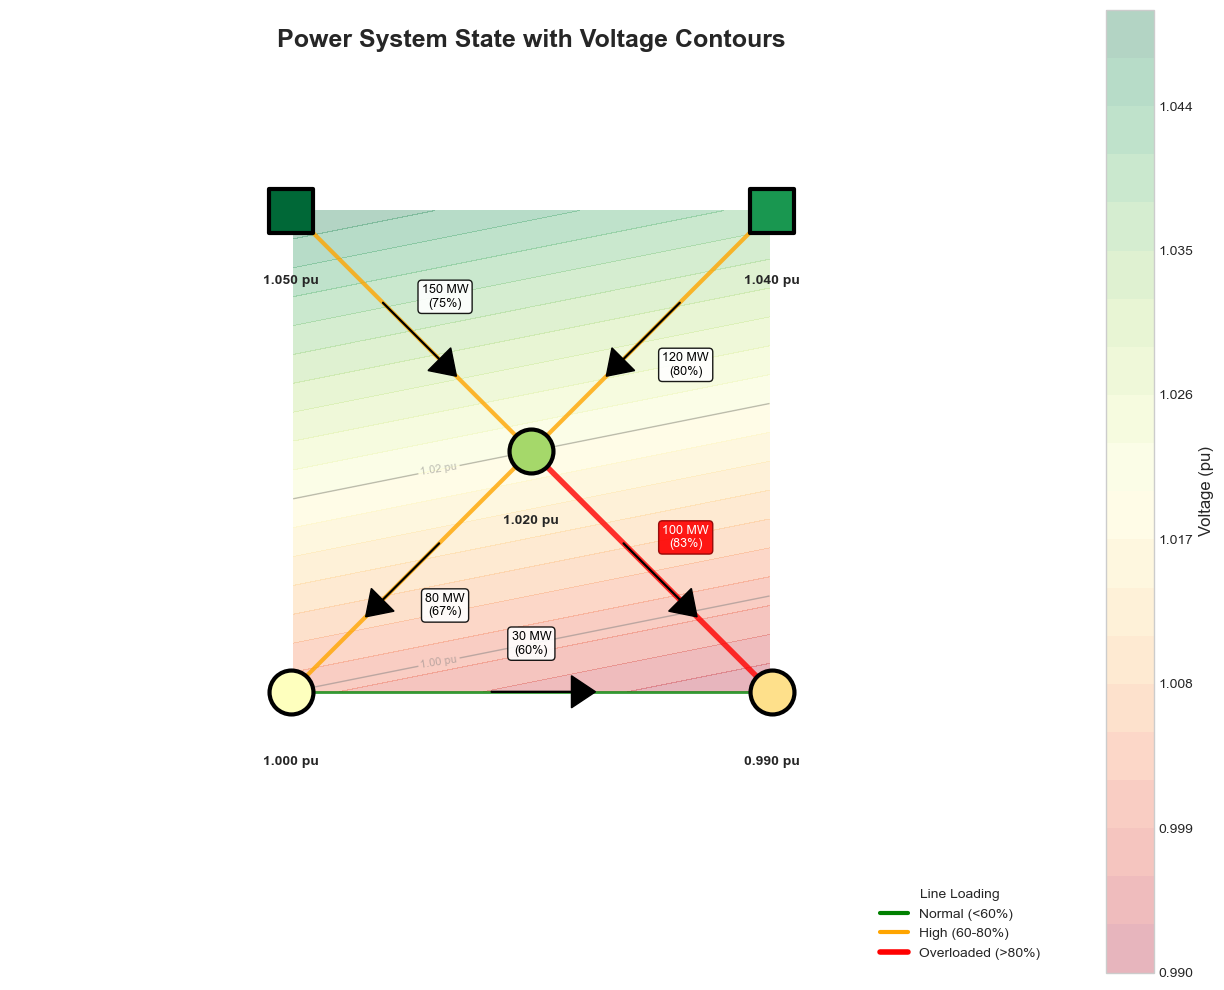

System Summary:
Voltage range: 0.990 - 1.050 pu
Overloaded lines: 1 out of 5
Average line loading: 73.0%


In [18]:
# Solution
from scipy.interpolate import griddata

fig, ax = plt.subplots(figsize=(14, 10))

# Line ratings (MW)
line_ratings = {
    (1, 3): 200,
    (2, 3): 150,
    (3, 4): 120,
    (3, 5): 120,
    (4, 5): 50
}

# Create voltage contour background
# Create grid for interpolation
x_coords = [pos[0] for pos in bus_positions.values()]
y_coords = [pos[1] for pos in bus_positions.values()]
v_values = list(voltages.values())

xi = np.linspace(-0.1, 1.1, 100)
yi = np.linspace(-0.1, 1.0, 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate voltage values
zi = griddata((x_coords, y_coords), v_values, (xi, yi), method='cubic')

# Plot contour
contour = ax.contourf(xi, yi, zi, levels=20, cmap='RdYlGn', alpha=0.3)
contour_lines = ax.contour(xi, yi, zi, levels=[0.95, 0.98, 1.00, 1.02, 1.05], 
                          colors='gray', linewidths=1, alpha=0.5)
ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%0.2f pu')

# Draw buses with voltage-based colors
voltage_colors = plt.cm.RdYlGn((np.array(list(voltages.values())) - 0.95) / 0.1)
for bus_id, (x, y) in bus_positions.items():
    color = voltage_colors[bus_id-1]
    if bus_id in [1, 2]:  # Generator buses
        ax.scatter(x, y, s=1000, c=[color], marker='s', 
                  edgecolors='black', linewidth=3, zorder=5)
        ax.text(x, y, f'G{bus_id}', ha='center', va='center', 
                fontsize=14, fontweight='bold', color='white')
    else:  # Load buses
        ax.scatter(x, y, s=1000, c=[color], marker='o', 
                  edgecolors='black', linewidth=3, zorder=5)
        ax.text(x, y, f'B{bus_id}', ha='center', va='center', 
                fontsize=14, fontweight='bold')
    
    # Add voltage value
    ax.text(x, y - 0.08, f'{voltages[bus_id]:.3f} pu', 
           ha='center', va='top', fontsize=10, fontweight='bold')

# Draw lines with loading indication
for from_bus, to_bus, flow in lines:
    x1, y1 = bus_positions[from_bus]
    x2, y2 = bus_positions[to_bus]
    
    # Calculate loading percentage
    rating = line_ratings.get((from_bus, to_bus), line_ratings.get((to_bus, from_bus), 100))
    loading_pct = flow / rating * 100
    
    # Color based on loading
    if loading_pct > 80:
        line_color = 'red'
        line_width = 4
    elif loading_pct > 60:
        line_color = 'orange'
        line_width = 3
    else:
        line_color = 'green'
        line_width = 2
    
    # Draw line
    ax.plot([x1, x2], [y1, y2], color=line_color, linewidth=line_width, 
           zorder=1, alpha=0.8)
    
    # Calculate midpoint for labels
    mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
    
    # Calculate flow direction
    dx, dy = x2 - x1, y2 - y1
    length = np.sqrt(dx**2 + dy**2)
    dx_norm, dy_norm = dx / length, dy / length
    
    # Draw flow arrow
    arrow_start_x = mid_x - 0.05 * dx_norm
    arrow_start_y = mid_y - 0.05 * dy_norm
    ax.arrow(arrow_start_x, arrow_start_y, 0.1 * dx_norm, 0.1 * dy_norm, 
            head_width=0.04, head_length=0.03, fc='black', ec='black', zorder=3)
    
    # Add flow and loading labels
    perp_x, perp_y = -dy_norm * 0.06, dx_norm * 0.06
    label_text = f'{flow} MW\n({loading_pct:.0f}%)'
    
    # Highlight overloaded lines
    bbox_props = dict(boxstyle='round,pad=0.3', alpha=0.9)
    if loading_pct > 80:
        bbox_props['facecolor'] = 'red'
        bbox_props['edgecolor'] = 'darkred'
        text_color = 'white'
    else:
        bbox_props['facecolor'] = 'white'
        text_color = 'black'
    
    ax.text(mid_x + perp_x, mid_y + perp_y, label_text, 
           ha='center', va='center', fontsize=9,
           bbox=bbox_props, color=text_color)

# Add title and colorbar
ax.text(0.5, 0.98, 'Power System State with Voltage Contours', 
        ha='center', va='top', fontsize=18, fontweight='bold', 
        transform=ax.transAxes)

# Add colorbar for voltage
cbar = plt.colorbar(contour, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Voltage (pu)', fontsize=12)

# Add loading legend
loading_legend = [
    plt.Line2D([0], [0], color='green', linewidth=3, label='Normal (<60%)'),
    plt.Line2D([0], [0], color='orange', linewidth=3, label='High (60-80%)'),
    plt.Line2D([0], [0], color='red', linewidth=4, label='Overloaded (>80%)')
]
ax.legend(handles=loading_legend, loc='lower right', title='Line Loading')

# Format plot
ax.set_xlim(-0.15, 1.15)
ax.set_ylim(-0.15, 1.05)
ax.set_aspect('equal')
ax.axis('off')

plt.tight_layout()
plt.show()

# Summary statistics
print("System Summary:")
print(f"Voltage range: {min(voltages.values()):.3f} - {max(voltages.values()):.3f} pu")
overloaded = sum(1 for (f, t, flow) in lines 
                if flow / line_ratings.get((f, t), line_ratings.get((t, f), 100)) > 0.8)
print(f"Overloaded lines: {overloaded} out of {len(lines)}")
avg_loading = np.mean([flow / line_ratings.get((f, t), line_ratings.get((t, f), 100)) * 100 
                      for (f, t, flow) in lines])
print(f"Average line loading: {avg_loading:.1f}%")

## 6. Dashboard Design

Effective dashboards combine multiple visualizations to provide a comprehensive view of system conditions. Here's how to create a power system monitoring dashboard.

```{admonition} Exercise 5: Design Your Own Dashboard
:class: tip

Create a custom dashboard focused on renewable integration that includes:
1. Current renewable penetration gauge
2. 48-hour forecast of wind and solar
3. Curtailment analysis chart
4. Storage requirements visualization
5. Carbon emissions tracking

```

In [19]:
# Exercise 5: Your code here
# Create renewable integration dashboard

# Your solution:

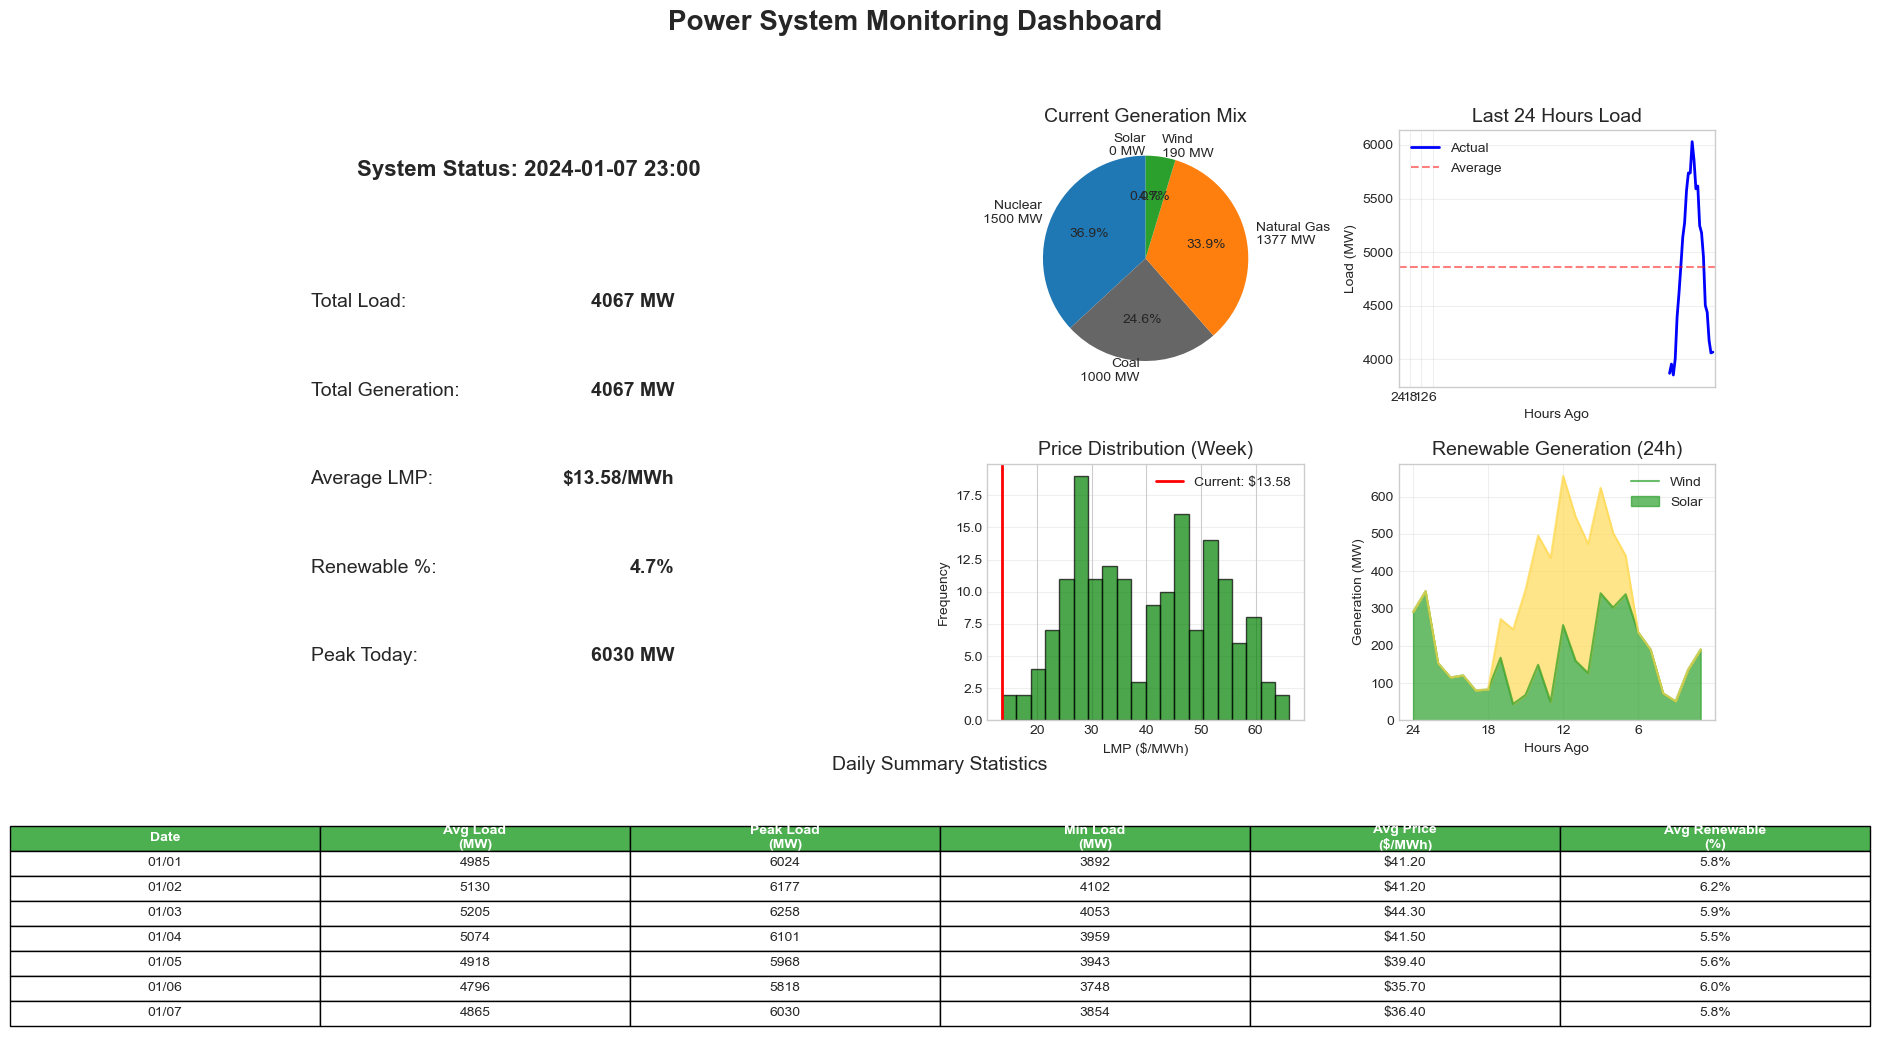


=== System Alerts ===
⚠️  Low renewable generation


In [22]:
# Create a comprehensive power system dashboard
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# Get current hour data (latest)
current_idx = len(generation_data) - 1
current_data = generation_data.iloc[current_idx]
current_time = current_data['timestamp']

# 1. Current System Status (top left, 2x2)
ax1 = fig.add_subplot(gs[0:2, 0:2])
ax1.text(0.5, 0.95, f'System Status: {current_time.strftime("%Y-%m-%d %H:%M")}', 
         ha='center', va='top', fontsize=16, fontweight='bold', transform=ax1.transAxes)

# Key metrics
metrics = [
    ('Total Load', f"{current_data['load']:.0f} MW"),
    ('Total Generation', f"{current_data[gen_types].sum():.0f} MW"),
    ('Average LMP', f"${current_data['lmp']:.2f}/MWh"),
    ('Renewable %', f"{current_data['renewable_pct']:.1f}%"),
    ('Peak Today', f"{generation_data[generation_data['day'] == current_data['day']]['load'].max():.0f} MW")
]

y_pos = 0.7
for metric, value in metrics:
    ax1.text(0.2, y_pos, metric + ':', fontsize=14, transform=ax1.transAxes)
    ax1.text(0.7, y_pos, value, fontsize=14, fontweight='bold', 
            transform=ax1.transAxes, ha='right')
    y_pos -= 0.15

ax1.axis('off')

# 2. Generation Mix Pie Chart (top right)
ax2 = fig.add_subplot(gs[0, 2])
gen_values = [current_data[gen] for gen in gen_types]
gen_labels = [f'{label}\n{val:.0f} MW' for label, val in zip(labels, gen_values)]
ax2.pie(gen_values, labels=gen_labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax2.set_title('Current Generation Mix', fontsize=14)

# 3. 24-Hour Load Forecast (top right)
ax3 = fig.add_subplot(gs[0, 3])
last_24h = generation_data.iloc[-24:]
ax3.plot(last_24h.index, last_24h['load'], 'b-', linewidth=2, label='Actual')
ax3.axhline(y=last_24h['load'].mean(), color='red', linestyle='--', alpha=0.5, label='Average')
ax3.set_xlabel('Hours Ago')
ax3.set_ylabel('Load (MW)')
ax3.set_title('Last 24 Hours Load', fontsize=14)
ax3.grid(True, alpha=0.3)
ax3.legend()
ax3.set_xticks(range(0, 24, 6))
ax3.set_xticklabels(['24', '18', '12', '6'])

# 4. Price Distribution (middle left)
ax4 = fig.add_subplot(gs[1, 2])
ax4.hist(generation_data['lmp'], bins=20, color='green', alpha=0.7, edgecolor='black')
ax4.axvline(current_data['lmp'], color='red', linewidth=2, label=f'Current: ${current_data["lmp"]:.2f}')
ax4.set_xlabel('LMP ($/MWh)')
ax4.set_ylabel('Frequency')
ax4.set_title('Price Distribution (Week)', fontsize=14)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# 5. Renewable Output (middle right)
ax5 = fig.add_subplot(gs[1, 3])
renewable_24h = last_24h[['wind', 'solar']].copy()
renewable_24h.index = range(24)
renewable_24h.plot(kind='area', stacked=True, ax=ax5, color=['#2ca02c', '#ffdb58'], alpha=0.7)
ax5.set_xlabel('Hours Ago')
ax5.set_ylabel('Generation (MW)')
ax5.set_title('Renewable Generation (24h)', fontsize=14)
ax5.set_xticks(range(0, 24, 6))
ax5.set_xticklabels(['24', '18', '12', '6'])
ax5.grid(True, alpha=0.3)
ax5.legend(['Wind', 'Solar'])

# 6. System Performance Indicators (bottom, full width)
ax6 = fig.add_subplot(gs[2, :])

# Calculate daily statistics
daily_stats = generation_data.groupby('day').agg({
    'load': ['mean', 'max', 'min'],
    'lmp': 'mean',
    'renewable_pct': 'mean'
}).round(1)

# Create table
cell_text = []
for date in daily_stats.index:
    row = [
        date.strftime('%m/%d'),
        f"{daily_stats.loc[date, ('load', 'mean')]:.0f}",
        f"{daily_stats.loc[date, ('load', 'max')]:.0f}",
        f"{daily_stats.loc[date, ('load', 'min')]:.0f}",
        f"${daily_stats.loc[date, ('lmp', 'mean')]:.2f}",
        f"{daily_stats.loc[date, ('renewable_pct', 'mean')]:.1f}%"
    ]
    cell_text.append(row)

columns = ['Date', 'Avg Load\n(MW)', 'Peak Load\n(MW)', 'Min Load\n(MW)', 
           'Avg Price\n($/MWh)', 'Avg Renewable\n(%)']

table = ax6.table(cellText=cell_text, colLabels=columns, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

# Style the table
for i in range(len(columns)):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

ax6.set_title('Daily Summary Statistics', fontsize=14, pad=20)
ax6.axis('off')

# Overall title
fig.suptitle('Power System Monitoring Dashboard', fontsize=20, fontweight='bold')

plt.tight_layout()
plt.show()

# Print alerts if any
print("\n=== System Alerts ===")
if current_data['load'] > generation_data['load'].quantile(0.95):
    print("⚠️  High load condition - above 95th percentile")
if current_data['renewable_pct'] < 10:
    print("⚠️  Low renewable generation")
if current_data['lmp'] > generation_data['lmp'].quantile(0.90):
    print("⚠️  High price alert - above 90th percentile")

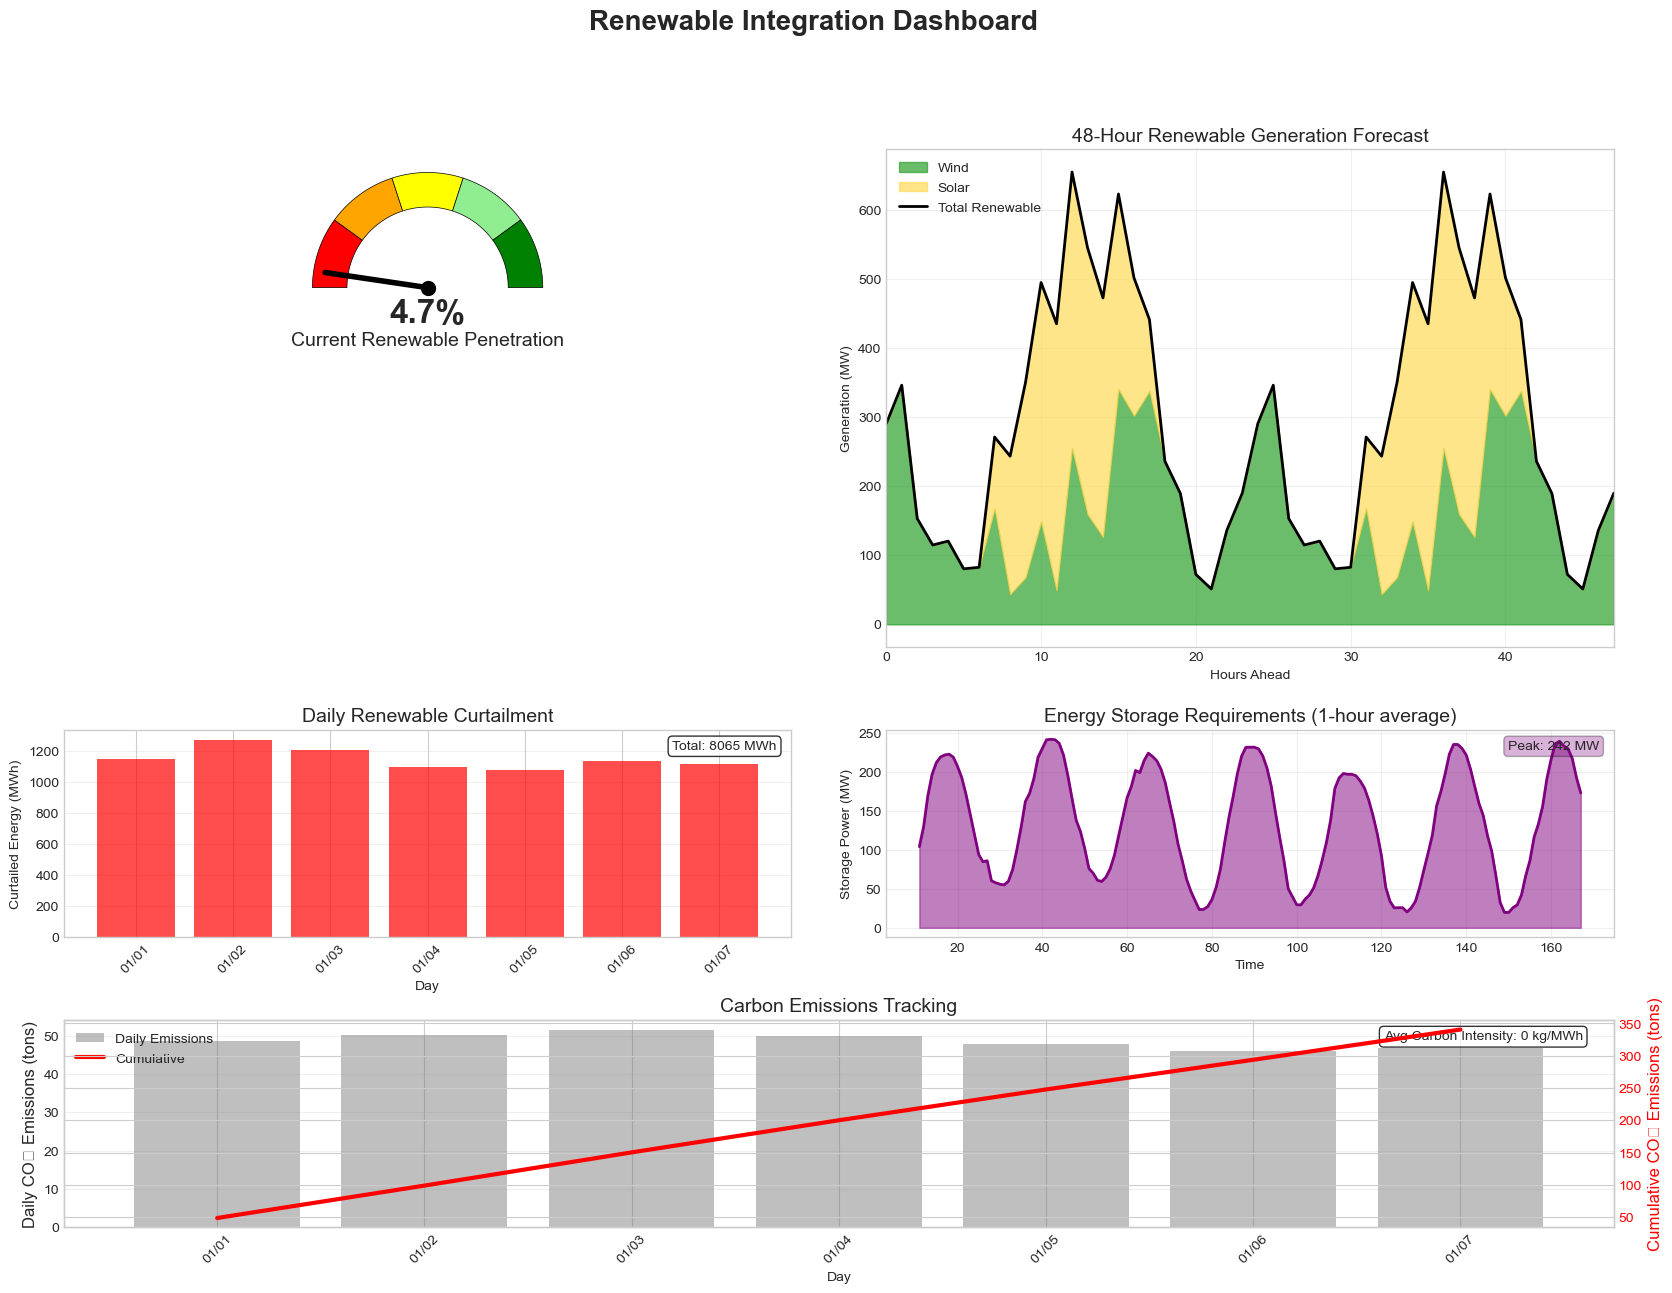


=== Renewable Integration Summary ===
Average Renewable Penetration: 5.8%
Peak Renewable Penetration: 12.4%
Total Curtailment: 8065 MWh
Total Carbon Emissions: 341 tons
Carbon Reduction vs All-Fossil: 100.0%


In [23]:
# Solution
# Create comprehensive renewable integration dashboard
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 4, hspace=0.4, wspace=0.3)

# Calculate additional renewable metrics
# Simulate curtailment (when renewable available > needed)
renewable_available = generation_data['wind'] * 1.2 + generation_data['solar'] * 1.1  # Simulate available
renewable_actual = generation_data['wind'] + generation_data['solar']
generation_data['curtailment'] = np.maximum(0, renewable_available - renewable_actual)

# Carbon emissions (simplified: coal=900, gas=400 kg/MWh)
generation_data['carbon_tons'] = (generation_data['coal'] * 0.9 + 
                                  generation_data['natural_gas'] * 0.4) / 1000

# Storage requirements (simplified: excess renewable that could be stored)
generation_data['storage_need'] = np.maximum(0, renewable_actual - 200)  # Assume 200 MW can be absorbed

# 1. Renewable Penetration Gauge (top left)
ax1 = fig.add_subplot(gs[0, 0:2])
current_renewable_pct = current_data['renewable_pct']

# Create gauge chart
theta = np.linspace(0, np.pi, 100)
r_inner, r_outer = 0.7, 1.0

# Color zones
colors_gauge = ['red', 'orange', 'yellow', 'lightgreen', 'green']
boundaries = [0, 20, 40, 60, 80, 100]

for i in range(len(colors_gauge)):
    theta_start = np.pi * (1 - boundaries[i]/100)
    theta_end = np.pi * (1 - boundaries[i+1]/100)
    theta_zone = np.linspace(theta_start, theta_end, 20)
    
    x_inner = r_inner * np.cos(theta_zone)
    y_inner = r_inner * np.sin(theta_zone)
    x_outer = r_outer * np.cos(theta_zone)
    y_outer = r_outer * np.sin(theta_zone)
    
    verts = list(zip(x_outer, y_outer)) + list(zip(x_inner[::-1], y_inner[::-1]))
    poly = plt.Polygon(verts, facecolor=colors_gauge[i], edgecolor='black', linewidth=0.5)
    ax1.add_patch(poly)

# Add needle
needle_angle = np.pi * (1 - current_renewable_pct/100)
needle_x = [0, 0.9 * np.cos(needle_angle)]
needle_y = [0, 0.9 * np.sin(needle_angle)]
ax1.plot(needle_x, needle_y, 'k-', linewidth=4)
ax1.scatter([0], [0], s=100, c='black', zorder=5)

# Labels
ax1.text(0, -0.3, f'{current_renewable_pct:.1f}%', ha='center', fontsize=24, fontweight='bold')
ax1.text(0, -0.5, 'Current Renewable Penetration', ha='center', fontsize=14)

ax1.set_xlim(-1.2, 1.2)
ax1.set_ylim(-0.6, 1.2)
ax1.set_aspect('equal')
ax1.axis('off')

# 2. 48-hour renewable forecast (top right)
ax2 = fig.add_subplot(gs[0:2, 2:])
# Extend forecast with simple pattern
forecast_hours = 48
future_wind = generation_data['wind'].iloc[-24:].tolist() * 2
future_solar = generation_data['solar'].iloc[-24:].tolist() * 2
forecast_time = pd.date_range(current_time, periods=forecast_hours, freq='H')

ax2.fill_between(range(forecast_hours), 0, future_wind, alpha=0.7, color='#2ca02c', label='Wind')
ax2.fill_between(range(forecast_hours), future_wind, 
                [w+s for w,s in zip(future_wind, future_solar)], 
                alpha=0.7, color='#ffdb58', label='Solar')
ax2.plot(range(forecast_hours), [w+s for w,s in zip(future_wind, future_solar)], 
         'k-', linewidth=2, label='Total Renewable')

ax2.set_xlabel('Hours Ahead')
ax2.set_ylabel('Generation (MW)')
ax2.set_title('48-Hour Renewable Generation Forecast', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 47)

# 3. Curtailment Analysis (middle left)
ax3 = fig.add_subplot(gs[2, 0:2])
daily_curtailment = generation_data.groupby('day')['curtailment'].sum()
ax3.bar(range(len(daily_curtailment)), daily_curtailment.values, color='red', alpha=0.7)
ax3.set_xlabel('Day')
ax3.set_ylabel('Curtailed Energy (MWh)')
ax3.set_title('Daily Renewable Curtailment', fontsize=14)
ax3.set_xticks(range(len(daily_curtailment)))
ax3.set_xticklabels([d.strftime('%m/%d') for d in daily_curtailment.index], rotation=45)
ax3.grid(True, alpha=0.3, axis='y')

# Add total curtailment
total_curtailment = daily_curtailment.sum()
ax3.text(0.98, 0.95, f'Total: {total_curtailment:.0f} MWh', 
         transform=ax3.transAxes, ha='right', va='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Storage Requirements (middle right)
ax4 = fig.add_subplot(gs[2, 2:])
storage_duration = generation_data['storage_need'].rolling(window=12).mean()  # 1-hour average
ax4.fill_between(generation_data.index, 0, storage_duration, alpha=0.5, color='purple')
ax4.plot(generation_data.index, storage_duration, 'purple', linewidth=2)
ax4.set_xlabel('Time')
ax4.set_ylabel('Storage Power (MW)')
ax4.set_title('Energy Storage Requirements (1-hour average)', fontsize=14)
ax4.grid(True, alpha=0.3)

# Calculate storage energy needed
max_storage_power = storage_duration.max()
ax4.text(0.98, 0.95, f'Peak: {max_storage_power:.0f} MW', 
         transform=ax4.transAxes, ha='right', va='top',
         bbox=dict(boxstyle='round', facecolor='purple', alpha=0.3))

# 5. Carbon Emissions Tracking (bottom)
ax5 = fig.add_subplot(gs[3, :])
carbon_hourly = generation_data.set_index('timestamp')['carbon_tons']
carbon_daily = carbon_hourly.resample('D').sum()

ax5_twin = ax5.twinx()
# Daily bars
bars = ax5.bar(range(len(carbon_daily)), carbon_daily.values, 
               alpha=0.5, color='gray', label='Daily Emissions')
# Cumulative line
cumulative = carbon_daily.cumsum()
line = ax5_twin.plot(range(len(carbon_daily)), cumulative.values, 
                    'r-', linewidth=3, label='Cumulative')[0]

ax5.set_xlabel('Day')
ax5.set_ylabel('Daily CO₂ Emissions (tons)', fontsize=12)
ax5_twin.set_ylabel('Cumulative CO₂ Emissions (tons)', fontsize=12, color='red')
ax5.set_title('Carbon Emissions Tracking', fontsize=14)
ax5.set_xticks(range(len(carbon_daily)))
ax5.set_xticklabels([d.strftime('%m/%d') for d in carbon_daily.index], rotation=45)
ax5_twin.tick_params(axis='y', labelcolor='red')
ax5.grid(True, alpha=0.3, axis='y')

# Combined legend
ax5.legend([bars, line], ['Daily Emissions', 'Cumulative'], loc='upper left')

# Calculate carbon intensity
avg_carbon_intensity = generation_data['carbon_tons'].sum() / generation_data[gen_types].sum().sum() * 1000
ax5.text(0.98, 0.95, f'Avg Carbon Intensity: {avg_carbon_intensity:.0f} kg/MWh', 
         transform=ax5.transAxes, ha='right', va='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Overall title
fig.suptitle('Renewable Integration Dashboard', fontsize=20, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary metrics
print("\n=== Renewable Integration Summary ===")
print(f"Average Renewable Penetration: {generation_data['renewable_pct'].mean():.1f}%")
print(f"Peak Renewable Penetration: {generation_data['renewable_pct'].max():.1f}%")
print(f"Total Curtailment: {generation_data['curtailment'].sum():.0f} MWh")
print(f"Total Carbon Emissions: {generation_data['carbon_tons'].sum():.0f} tons")
print(f"Carbon Reduction vs All-Fossil: {(1 - avg_carbon_intensity/900)*100:.1f}%")

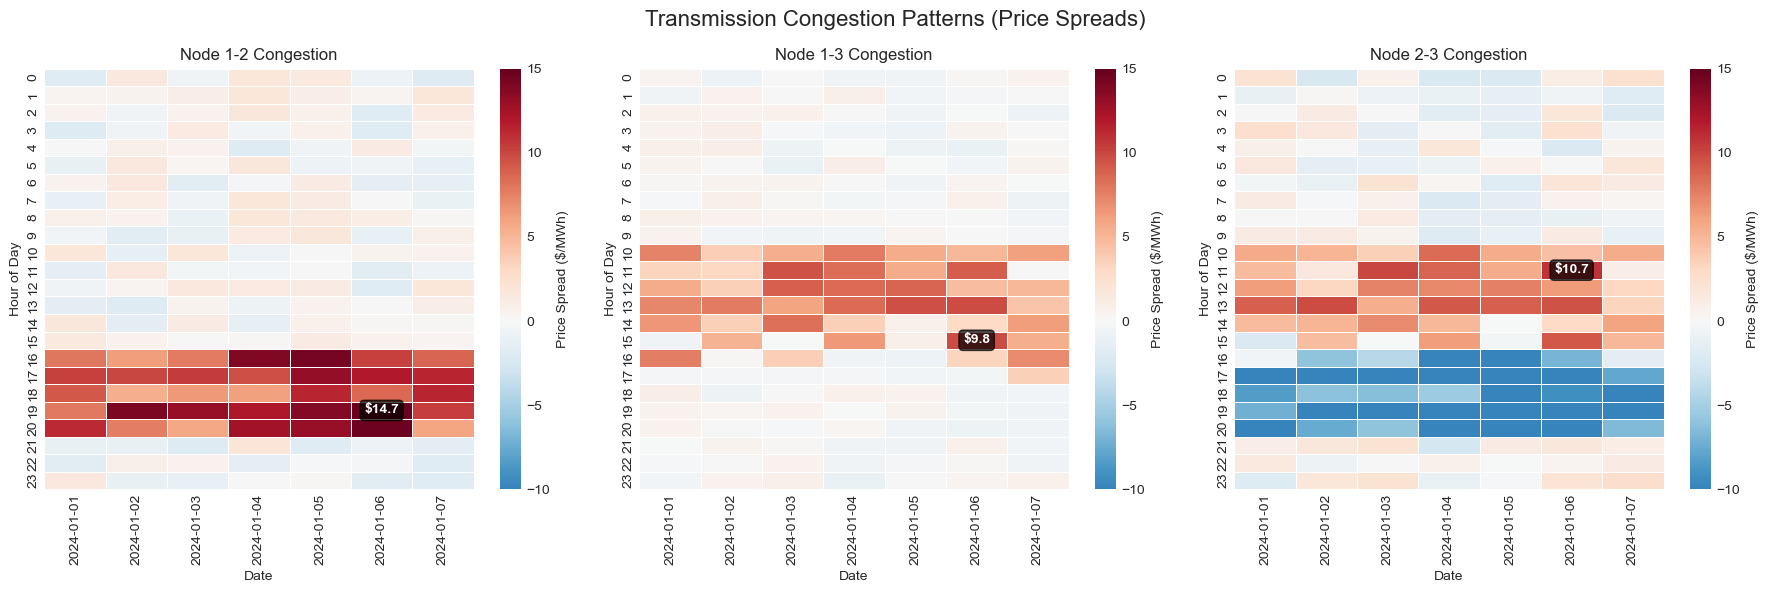

Congestion Summary:

Average price spreads by hour:
      spread_1_2  spread_1_3  spread_2_3
hour                                    
0          -0.06       -0.14       -0.08
1           0.98        0.05       -0.94
2           0.37        0.09       -0.28
3          -0.27        0.10        0.38
4           0.00       -0.06       -0.06
5          -0.03        0.07        0.10
6          -0.20        0.14        0.34
7           0.21        0.06       -0.16
8           0.71        0.26       -0.45
9          -0.05       -0.10       -0.05
10          0.38        5.86        5.49
11         -0.47        5.58        6.05
12          0.57        6.43        5.86
13         -0.29        7.63        7.92
14          0.16        4.57        4.41
15          0.65        3.85        3.20
16          9.87        2.92       -6.95
17         10.97        0.23      -10.74
18          8.37        0.07       -8.29
19         12.28        0.15      -12.13
20         10.09       -0.17      -10.26
21   

In [24]:
# Solution
# Create synthetic nodal prices with congestion patterns
np.random.seed(42)

# Node 1 is reference (similar to original LMP)
node1_prices = generation_data['lmp'].copy()

# Node 2 has congestion during peak hours
congestion_factor2 = np.where(generation_data['hour'].between(16, 20), 
                             np.random.uniform(5, 15, len(generation_data)), 
                             np.random.uniform(-2, 2, len(generation_data)))
node2_prices = node1_prices + congestion_factor2

# Node 3 has congestion when renewables are high
renewable_gen = generation_data['wind'] + generation_data['solar']
high_renewable = renewable_gen > renewable_gen.quantile(0.75)
congestion_factor3 = np.where(high_renewable, 
                             np.random.uniform(3, 10, len(generation_data)), 
                             np.random.uniform(-1, 1, len(generation_data)))
node3_prices = node1_prices + congestion_factor3

# Create price spread data
price_data = pd.DataFrame({
    'timestamp': generation_data['timestamp'],
    'hour': generation_data['hour'],
    'day': generation_data['day'],
    'node1': node1_prices,
    'node2': node2_prices,
    'node3': node3_prices,
    'spread_1_2': node2_prices - node1_prices,
    'spread_1_3': node3_prices - node1_prices,
    'spread_2_3': node3_prices - node2_prices
})

# Create congestion heatmap
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Heatmap for each spread
spreads = ['spread_1_2', 'spread_1_3', 'spread_2_3']
titles = ['Node 1-2 Congestion', 'Node 1-3 Congestion', 'Node 2-3 Congestion']

for ax, spread, title in zip(axes, spreads, titles):
    spread_matrix = price_data.pivot_table(values=spread, index='hour', columns='day')
    im = sns.heatmap(spread_matrix, cmap='RdBu_r', center=0, ax=ax,
                     cbar_kws={'label': 'Price Spread ($/MWh)'}, 
                     vmin=-10, vmax=15, linewidths=0.5)
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Hour of Day')
    
    # Find and annotate most congested hour
    max_congestion_idx = price_data[spread].idxmax()
    max_hour = price_data.loc[max_congestion_idx, 'hour']
    max_day = price_data.loc[max_congestion_idx, 'day']
    max_value = price_data.loc[max_congestion_idx, spread]
    
    # Find position in matrix
    day_idx = list(spread_matrix.columns).index(max_day)
    ax.text(day_idx + 0.5, max_hour + 0.5, f'${max_value:.1f}', 
            ha='center', va='center', color='white', fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))

plt.suptitle('Transmission Congestion Patterns (Price Spreads)', fontsize=16)
plt.tight_layout()
plt.show()

# Summary statistics
print("Congestion Summary:")
print("\nAverage price spreads by hour:")
hourly_congestion = price_data.groupby('hour')[spreads].mean()
print(hourly_congestion.round(2))

print("\nMost congested periods:")
for spread in spreads:
    max_idx = price_data[spread].idxmax()
    print(f"{spread}: {price_data.loc[max_idx, 'timestamp']} - ${price_data.loc[max_idx, spread]:.2f}/MWh")

# Calculate total congestion cost (simplified)
print("\nEstimated congestion costs (assuming 100 MW transfers):")
for spread in spreads:
    total_cost = (price_data[spread] * 100).sum()  # $/h * MW = $/h, sum for total
    print(f"{spread}: ${total_cost:,.0f}")

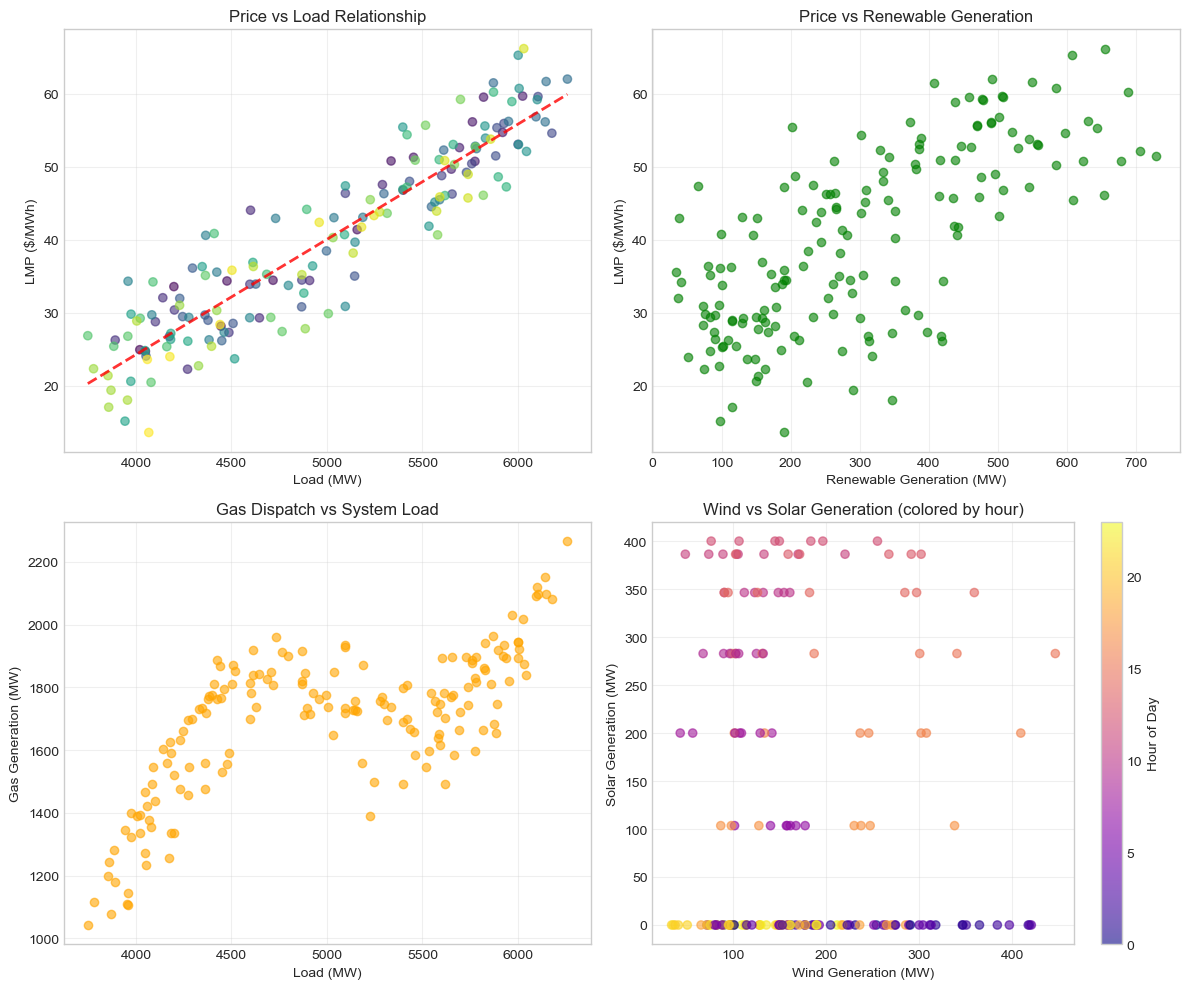

Key Correlations:
Load vs Price: 0.923
Renewable vs Price: 0.705
Load vs Gas: 0.695
Wind vs Solar: -0.094


In [25]:
# Create scatter plot matrix for key relationships
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Load vs Price
ax = axes[0, 0]
scatter = ax.scatter(generation_data['load'], generation_data['lmp'], 
                    c=generation_data.index, cmap='viridis', alpha=0.6)
ax.set_xlabel('Load (MW)')
ax.set_ylabel('LMP ($/MWh)')
ax.set_title('Price vs Load Relationship')
ax.grid(True, alpha=0.3)

# Add regression line
z = np.polyfit(generation_data['load'], generation_data['lmp'], 1)
p = np.poly1d(z)
ax.plot(generation_data['load'].sort_values(), 
        p(generation_data['load'].sort_values()), 
        "r--", alpha=0.8, linewidth=2)

# 2. Renewable Generation vs Price
ax = axes[0, 1]
renewable_total = generation_data['wind'] + generation_data['solar']
ax.scatter(renewable_total, generation_data['lmp'], 
          alpha=0.6, color='green')
ax.set_xlabel('Renewable Generation (MW)')
ax.set_ylabel('LMP ($/MWh)')
ax.set_title('Price vs Renewable Generation')
ax.grid(True, alpha=0.3)

# 3. Gas Generation vs Load (dispatch relationship)
ax = axes[1, 0]
ax.scatter(generation_data['load'], generation_data['natural_gas'], 
          alpha=0.6, color='orange')
ax.set_xlabel('Load (MW)')
ax.set_ylabel('Gas Generation (MW)')
ax.set_title('Gas Dispatch vs System Load')
ax.grid(True, alpha=0.3)

# 4. Wind vs Solar (complementarity)
ax = axes[1, 1]
ax.scatter(generation_data['wind'], generation_data['solar'], 
          alpha=0.6, c=generation_data['timestamp'].dt.hour, cmap='plasma')
ax.set_xlabel('Wind Generation (MW)')
ax.set_ylabel('Solar Generation (MW)')
ax.set_title('Wind vs Solar Generation (colored by hour)')
ax.grid(True, alpha=0.3)

# Add colorbar for the last plot
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label('Hour of Day')

plt.tight_layout()
plt.show()

# Calculate correlations
print("Key Correlations:")
print(f"Load vs Price: {generation_data['load'].corr(generation_data['lmp']):.3f}")
print(f"Renewable vs Price: {renewable_total.corr(generation_data['lmp']):.3f}")
print(f"Load vs Gas: {generation_data['load'].corr(generation_data['natural_gas']):.3f}")
print(f"Wind vs Solar: {generation_data['wind'].corr(generation_data['solar']):.3f}")

### Scatter Plots for Relationship Analysis

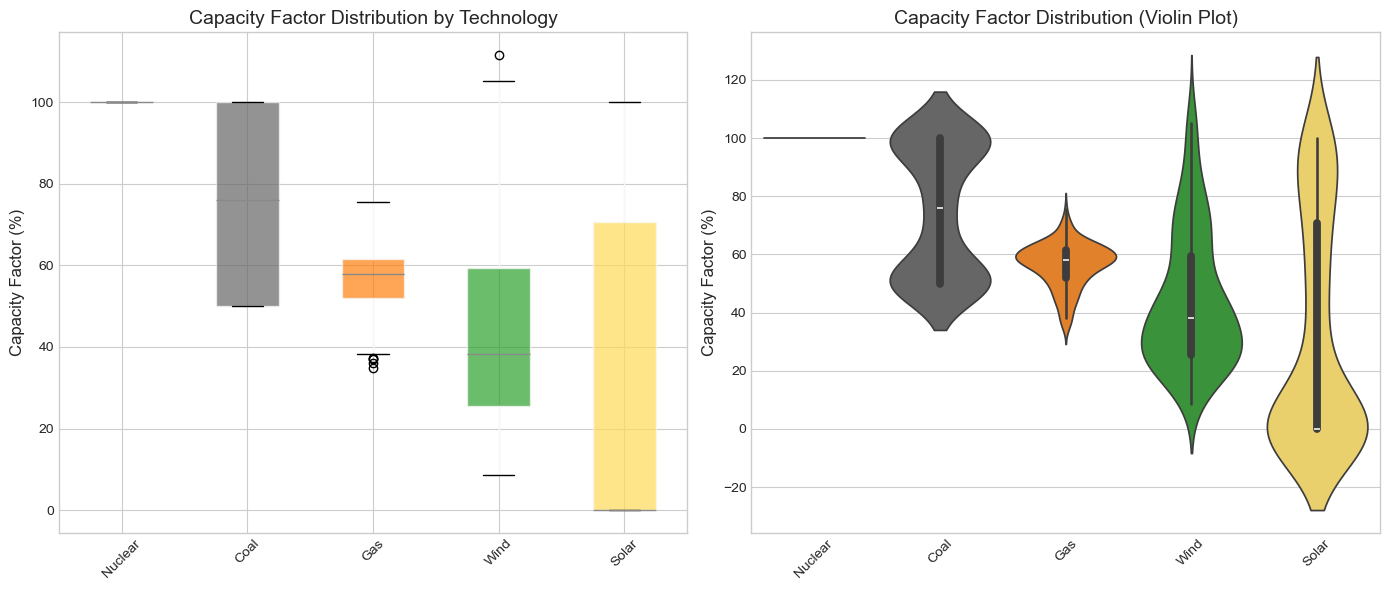

Capacity Factor Statistics:
       nuclear    coal  natural_gas    wind     solar
count    168.0  168.00       168.00  168.00  1.68e+02
mean     100.0   75.02        56.41   44.18  3.16e+01
std        0.0   22.23         7.76   23.56  3.88e+01
min      100.0   50.00        34.77    8.62  0.00e+00
25%      100.0   50.00        52.01   25.59  0.00e+00
50%      100.0   75.97        57.93   38.31  6.12e-15
75%      100.0  100.00        61.58   59.29  7.07e+01
max      100.0  100.00        75.54  111.60  1.00e+02


In [26]:
# Calculate hourly capacity factors
capacity_factors = pd.DataFrame()
capacities = {'nuclear': 1500, 'coal': 2000, 'natural_gas': 3000, 'wind': 400, 'solar': 400}

for gen_type, capacity in capacities.items():
    capacity_factors[gen_type] = generation_data[gen_type] / capacity * 100

# Create side-by-side box and violin plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Box plot
capacity_factors.boxplot(ax=ax1, grid=True, patch_artist=True)
ax1.set_ylabel('Capacity Factor (%)', fontsize=12)
ax1.set_title('Capacity Factor Distribution by Technology', fontsize=14)
ax1.set_xticklabels(['Nuclear', 'Coal', 'Gas', 'Wind', 'Solar'], rotation=45)

# Color the boxes
boxes = ax1.findobj(plt.matplotlib.patches.PathPatch)
for box, color in zip(boxes, colors[:5]):
    box.set_facecolor(color)
    box.set_alpha(0.7)

# Violin plot for more detail
sns.violinplot(data=capacity_factors, ax=ax2, palette=colors[:5])
ax2.set_ylabel('Capacity Factor (%)', fontsize=12)
ax2.set_title('Capacity Factor Distribution (Violin Plot)', fontsize=14)
ax2.set_xticklabels(['Nuclear', 'Coal', 'Gas', 'Wind', 'Solar'], rotation=45)

plt.tight_layout()
plt.show()

# Print statistics
print("Capacity Factor Statistics:")
print(capacity_factors.describe())

### Box Plots and Violin Plots for Capacity Factor Analysis

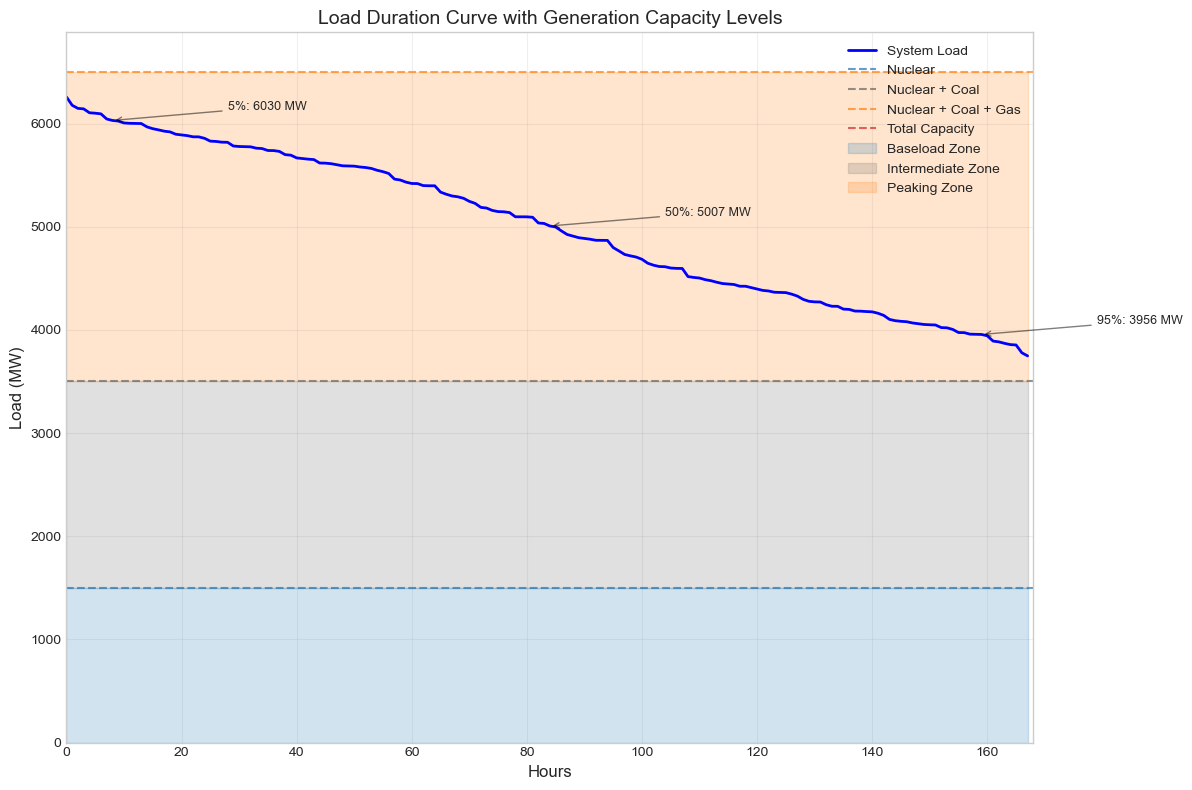

System Load Factor: 0.798


In [27]:
# Load Duration Curve - A fundamental power system plot
# Sort load values in descending order
load_sorted = np.sort(generation_data['load'].values)[::-1]
hours = np.arange(len(load_sorted))

# Calculate capacity levels for reference
capacity_levels = {
    'Nuclear': 1500,
    'Nuclear + Coal': 1500 + 2000,
    'Nuclear + Coal + Gas': 1500 + 2000 + 3000,
    'Total Capacity': 1500 + 2000 + 3000 + 400 + 400  # Including max renewables
}

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(hours, load_sorted, 'b-', linewidth=2, label='System Load')

# Add capacity reference lines
colors_cap = ['#1f77b4', '#666666', '#ff7f0e', '#d62728']
for i, (label, capacity) in enumerate(capacity_levels.items()):
    plt.axhline(y=capacity, color=colors_cap[i], linestyle='--', alpha=0.7, label=label)

# Add shading for different operational zones
plt.fill_between(hours, 0, capacity_levels['Nuclear'], alpha=0.2, color='#1f77b4', label='Baseload Zone')
plt.fill_between(hours, capacity_levels['Nuclear'], capacity_levels['Nuclear + Coal'], 
                 alpha=0.2, color='#666666', label='Intermediate Zone')
plt.fill_between(hours, capacity_levels['Nuclear + Coal'], capacity_levels['Nuclear + Coal + Gas'], 
                 alpha=0.2, color='#ff7f0e', label='Peaking Zone')

plt.xlabel('Hours', fontsize=12)
plt.ylabel('Load (MW)', fontsize=12)
plt.title('Load Duration Curve with Generation Capacity Levels', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.xlim(0, len(hours))
plt.ylim(0, load_sorted.max() * 1.1)

# Add annotations for key percentiles
percentiles = [5, 50, 95]
for p in percentiles:
    idx = int(len(hours) * p / 100)
    plt.annotate(f'{p}%: {load_sorted[idx]:.0f} MW', 
                xy=(idx, load_sorted[idx]), 
                xytext=(idx + 20, load_sorted[idx] + 100),
                arrowprops=dict(arrowstyle='->', alpha=0.5),
                fontsize=9)

plt.tight_layout()
plt.show()

# Calculate load factor
load_factor = generation_data['load'].mean() / generation_data['load'].max()
print(f"System Load Factor: {load_factor:.3f}")

## Visualization Best Practices for Power Systems

### Color Standards
Consistent color schemes improve readability and reduce cognitive load:

```python
# Standard color palette for fuel types
FUEL_COLORS = {
    'Nuclear': '#1f77b4',     # Blue
    'Coal': '#666666',        # Dark gray  
    'Natural Gas': '#ff7f0e', # Orange
    'Hydro': '#17becf',       # Cyan
    'Wind': '#2ca02c',        # Green
    'Solar': '#ffdb58',       # Yellow
    'Other': '#d62728'        # Red
}

# Voltage level colors
VOLTAGE_COLORS = {
    'Normal': 'green',        # 0.95-1.05 pu
    'Warning': 'orange',      # 0.93-0.95 or 1.05-1.07 pu
    'Violation': 'red'        # <0.93 or >1.07 pu
}
```

### Figure Standards
Professional figures follow consistent formatting:

```python
# Standard figure sizes
FIGURE_SIZES = {
    'single': (10, 6),
    'double': (14, 8),
    'dashboard': (20, 12)
}

# Font sizes
FONT_SIZES = {
    'title': 14,
    'axis_label': 12,
    'tick_label': 10,
    'annotation': 9
}
```

### Accessibility Considerations
- Use colorblind-friendly palettes when possible
- Include patterns or markers in addition to colors
- Ensure sufficient contrast between elements
- Add clear labels and legends

## Summary

This lesson covered essential visualization techniques for power system data:

### Key Techniques
1. **Time Series Plots**: Load profiles, generation stacks, dual-axis plots
2. **Statistical Visualizations**: Load duration curves, capacity factor distributions, scatter plots
3. **Heatmaps**: Price patterns, congestion analysis, correlation matrices
4. **Network Diagrams**: Power flow visualization, voltage contours
5. **Dashboards**: Combining multiple views for comprehensive monitoring

### Power System Applications
- **Operations**: Real-time monitoring, state estimation displays
- **Planning**: Capacity expansion visualizations, scenario comparisons
- **Markets**: Price analysis, congestion patterns, bid stack visualization
- **Reliability**: Outage analysis, contingency impact visualization
- **Renewables**: Integration studies, curtailment analysis, forecasting

### Tools and Libraries
- **Matplotlib**: Foundation for all plotting
- **Seaborn**: Statistical visualizations and heatmaps
- **Pandas**: Built-in plotting for quick exploration
- **Specialized**: NetworkX for larger networks, Plotly for interactive dashboards

## Next Steps

With these visualization skills, you can:
- Create publication-quality figures for reports and papers
- Build monitoring dashboards for operational use
- Communicate complex technical results to diverse audiences
- Explore and understand power system data patterns

In the next lesson, we'll apply these skills to time series analysis and forecasting for power systems.